# <center> Data Science Project

## Project Overview

**Problem Statement:** The effect of the type of democracy on government expenditure on education. 

- Time period considered: from 2008 to 2017 (10 years)
- Countries: UN member states
- Data sources:
    - V-DEM dataset (for democracy info) - downloaded
    - 'World Bank' dataset (for education budgets) - scraped 

## Data Acquisition

### Part 1 (obtaining data for education budgets)

In [758]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Web scraping
import requests
from bs4 import BeautifulSoup

# Converter
import country_converter as coco

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

# Other modules
import re
import time
import random
import sqlite3

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
## For continuous outcomes
from sklearn.linear_model import LinearRegression as LM
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn import tree # For plotting the decision tree rules
import statsmodels.formula.api as smf

## For discrete outcomes
from sklearn.tree import DecisionTreeClassifier as DTd
from sklearn.neighbors import KNeighborsClassifier as KNNd
from sklearn.ensemble import RandomForestClassifier as RFd

# For model interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance 
import eli5 # "explain it to me like I'm 5"
from eli5.sklearn import PermutationImportance

# For ICE plots
from pdpbox import pdp

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")

#### Get list of UN countries

In [2]:
# UN member states URL
un_url = "https://www.un.org/en/member-states/"

In [3]:
# page
page = requests.get(un_url)
page.status_code
200

200

In [4]:
# Parse the content 
soup = BeautifulSoup(page.content, 'html.parser')

In [5]:
soup.select(".member-state-name")

[<span class="member-state-name">Afghanistan</span>,
 <span class="member-state-name">Albania</span>,
 <span class="member-state-name">Algeria</span>,
 <span class="member-state-name">Andorra</span>,
 <span class="member-state-name">Angola</span>,
 <span class="member-state-name">Antigua and Barbuda</span>,
 <span class="member-state-name">Argentina</span>,
 <span class="member-state-name">Armenia</span>,
 <span class="member-state-name">Australia</span>,
 <span class="member-state-name">Austria</span>,
 <span class="member-state-name">Azerbaijan</span>,
 <span class="member-state-name">Bahamas</span>,
 <span class="member-state-name">Bahrain</span>,
 <span class="member-state-name">Bangladesh</span>,
 <span class="member-state-name">Barbados</span>,
 <span class="member-state-name">Belarus</span>,
 <span class="member-state-name">Belgium</span>,
 <span class="member-state-name">Belize</span>,
 <span class="member-state-name">Benin</span>,
 <span class="member-state-name">Bhutan</span>

In [6]:
# store UN member countries in a list

un_member_countries = []
for item in soup.select(".member-state-name"):
    un_member_countries.append(item.text)
    
print(un_member_countries)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica', "Côte D'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', "Democratic People's Republic of Korea", 'Democratic Republic of the Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia (Republic of The)', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea Bissau', 'Guyana

In [7]:
#standardize un member country names
standardized_un_countries = coco.convert(names=un_member_countries, to='name_short')
print(standardized_un_countries)

['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo Republic', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic', 'North Korea', 'DR Congo', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iran', 'Iraq', 

In [8]:
# convert list into a data frame
un_df = DataFrame(standardized_un_countries, columns = ['country'])
un_df

,country
0,Afghanistan
1,Albania
2,Algeria
3,Andorra
4,Angola
...,...
188,Venezuela
189,Vietnam
190,Yemen
191,Zambia


#### Modify list of country names to compare to country names scraped off of the website


In [40]:
un_country_list = []

for country in standardized_un_countries:
    country = country.lower()
    country = country.replace(' ','-')
    un_country_list.append(country)
    

In [41]:
un_country_list

['afghanistan',
 'albania',
 'algeria',
 'andorra',
 'angola',
 'antigua-and-barbuda',
 'argentina',
 'armenia',
 'australia',
 'austria',
 'azerbaijan',
 'bahamas',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bhutan',
 'bolivia',
 'bosnia-and-herzegovina',
 'botswana',
 'brazil',
 'brunei-darussalam',
 'bulgaria',
 'burkina-faso',
 'burundi',
 'cabo-verde',
 'cambodia',
 'cameroon',
 'canada',
 'central-african-republic',
 'chad',
 'chile',
 'china',
 'colombia',
 'comoros',
 'congo-republic',
 'costa-rica',
 "cote-d'ivoire",
 'croatia',
 'cuba',
 'cyprus',
 'czech-republic',
 'north-korea',
 'dr-congo',
 'denmark',
 'djibouti',
 'dominica',
 'dominican-republic',
 'ecuador',
 'egypt',
 'el-salvador',
 'equatorial-guinea',
 'eritrea',
 'estonia',
 'eswatini',
 'ethiopia',
 'fiji',
 'finland',
 'france',
 'gabon',
 'gambia',
 'georgia',
 'germany',
 'ghana',
 'greece',
 'grenada',
 'guatemala',
 'guinea',
 'guinea-bissau',
 'guyana',
 'haiti',

#### scrape countries off of webpage

In [11]:
# store url
url = "https://www.indexmundi.com/facts/"

In [12]:
# download entire webpage
page = requests.get(url)

# check connection
page.status_code # 200 == Connection

200

In [13]:
# parse content
soup = BeautifulSoup(page.content, 'html.parser')

In [14]:
# look at the raw code of the downloaded webpage
print(soup.prettify())

<!DOCTYPE html>
<html>
 <head>
  <title>
   Country Facts Explorer - IndexMundi
  </title>
  <meta content="IE=edge" http-equiv="X-UA-Compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <meta content="696085087" property="fb:admins"/>
  <meta content="article" property="og:type"/>
  <meta content="Country Facts Explorer - IndexMundi" property="og:title"/>
  <meta content="https://www.indexmundi.com/img/indexmundi-200x200.jpg" property="og:image"/>
  <meta content="600" property="og:image:width"/>
  <meta content="315" property="og:image:height"/>
  <meta content="477929958891399" property="fb:app_id"/>
  <meta content="summary" name="twitter:card"/>
  <meta content="@indexmundi" name="twitter:site"/>
  <meta content="Country Facts Explorer - IndexMundi" name="twitter:title"/>
  <meta content="Country Facts Explorer - IndexMundi" name="twitter:description"/>
  <meta content="https://www.indexmundi.com/img/indexmundi-200x200.jpg" name="twitter:image"/>

In [15]:
href_list = []

for tag in soup.find_all('a'):
    h_ref = tag.attrs.get("href")
    href = href_list.append(h_ref)

In [16]:
# view href_list
href_list

['/',
 '/',
 'http://www.worldbank.org/',
 '/facts/topics',
 '/es/datos/',
 '/facts/afghanistan',
 '/facts/albania',
 '/facts/algeria',
 '/facts/american-samoa',
 '/facts/andorra',
 '/facts/angola',
 '/facts/antigua-and-barbuda',
 '/facts/arab-world',
 '/facts/argentina',
 '/facts/armenia',
 '/facts/aruba',
 '/facts/australia',
 '/facts/austria',
 '/facts/azerbaijan',
 '/facts/bahrain',
 '/facts/bangladesh',
 '/facts/barbados',
 '/facts/belarus',
 '/facts/belgium',
 '/facts/belize',
 '/facts/benin',
 '/facts/bermuda',
 '/facts/bhutan',
 '/facts/bolivia',
 '/facts/bosnia-and-herzegovina',
 '/facts/botswana',
 '/facts/brazil',
 '/facts/british-virgin-islands',
 '/facts/brunei',
 '/facts/bulgaria',
 '/facts/burkina-faso',
 '/facts/burundi',
 '/facts/cabo-verde',
 '/facts/cambodia',
 '/facts/cameroon',
 '/facts/canada',
 '/facts/caribbean-small-states',
 '/facts/cayman-islands',
 '/facts/central-african-republic',
 '/facts/central-europe-and-the-baltics',
 '/facts/chad',
 '/facts/channel-i

In [29]:
## clean list

# create new list
href_list_countries = []

# get only countries
for item in href_list:
    if 'facts' in item and ('topics' not in item) and ('indicators' not in item):
        href_list_countries.append(item)

In [50]:
# remove '/facts' to get country names
website_country_list = [item.replace('/facts/', '') for item in href_list_countries]

In [213]:
website_country_list

['afghanistan',
 'albania',
 'algeria',
 'american-samoa',
 'andorra',
 'angola',
 'antigua-and-barbuda',
 'arab-world',
 'argentina',
 'armenia',
 'aruba',
 'australia',
 'austria',
 'azerbaijan',
 'bahrain',
 'bangladesh',
 'barbados',
 'belarus',
 'belgium',
 'belize',
 'benin',
 'bermuda',
 'bhutan',
 'bolivia',
 'bosnia-and-herzegovina',
 'botswana',
 'brazil',
 'british-virgin-islands',
 'brunei',
 'bulgaria',
 'burkina-faso',
 'burundi',
 'cabo-verde',
 'cambodia',
 'cameroon',
 'canada',
 'caribbean-small-states',
 'cayman-islands',
 'central-african-republic',
 'central-europe-and-the-baltics',
 'chad',
 'channel-islands',
 'chile',
 'china',
 'colombia',
 'comoros',
 'congo',
 'costa-rica',
 "c%C3%B4te-d'ivoire",
 'croatia',
 'cuba',
 'cura%C3%A7ao',
 'cyprus',
 'czech-republic',
 "dem.-people's-rep.-korea",
 'dem.-rep.-congo',
 'denmark',
 'djibouti',
 'dominica',
 'dominican-republic',
 'east-asia-%26-pacific',
 'east-asia-%26-pacific-(excluding-high-income)',
 'ecuador',
 

In [247]:
# convert un country list and website country list to data frames
un_countries_df = DataFrame(un_country_list, columns = ['country'])
website_countries_df = DataFrame(website_country_list, columns = ['country'])

In [248]:
# merge un_countries_df and website_countries_df; use 'Anti-join' to identify merge issues
merged_countries = pd.merge(left = un_countries_df, right = website_countries_df, how = 'left', on = "country", indicator = True)

In [377]:
# check if there were any observations that were 'left_only' merge
merged_countries.loc[merged_countries._merge == "left_only",:].drop(columns = "_merge").values

array([['bahamas'],
       ['brunei-darussalam'],
       ['congo-republic'],
       ["cote-d'ivoire"],
       ['north-korea'],
       ['dr-congo'],
       ['gambia'],
       ['laos'],
       ['micronesia,-fed.-sts.'],
       ['macedonia'],
       ['south-korea'],
       ['sao-tome-and-principe'],
       ['slovakia'],
       ['syria']], dtype=object)

In [71]:
website_countries_df.values

array([['afghanistan'],
       ['albania'],
       ['algeria'],
       ['american-samoa'],
       ['andorra'],
       ['angola'],
       ['antigua-and-barbuda'],
       ['arab-world'],
       ['argentina'],
       ['armenia'],
       ['aruba'],
       ['australia'],
       ['austria'],
       ['azerbaijan'],
       ['bahrain'],
       ['bangladesh'],
       ['barbados'],
       ['belarus'],
       ['belgium'],
       ['belize'],
       ['benin'],
       ['bermuda'],
       ['bhutan'],
       ['bolivia'],
       ['bosnia-and-herzegovina'],
       ['botswana'],
       ['brazil'],
       ['british-virgin-islands'],
       ['brunei'],
       ['bulgaria'],
       ['burkina-faso'],
       ['burundi'],
       ['cabo-verde'],
       ['cambodia'],
       ['cameroon'],
       ['canada'],
       ['caribbean-small-states'],
       ['cayman-islands'],
       ['central-african-republic'],
       ['central-europe-and-the-baltics'],
       ['chad'],
       ['channel-islands'],
       ['chile'],
      

The following countries are actually present in the website data so let's modify the dataframe:
- brunei-darussalam to brunei
- cote-d'ivoire to côte-d'ivoire
- gambia to the-gambia
- dr-congo to congo
- micronesia,-fed.-sts. to micronesia
- slovakia to slovak-republic
- syria to syrian-arab-republic

In [73]:
# drop merged column
merged_countries = merged_countries.drop(columns = '_merge')

In [78]:
merged_countries['country'] = merged_countries['country'].replace(['brunei-darussalam',"cote-d'ivoire",'gambia','dr-congo','micronesia,-fed.-sts.','slovakia','syria'],['brunei',"côte-d'ivoire",'the-gambia','congo','micronesia','slovak-republic','syrian-arab-republic'])

In [139]:
# convert dataframe to list
countries = list(merged_countries.country.values)

Now we have a list of UN member states that we can use to scrape data from the website. 

We can see that the URL structure is the following:
<br> https://www.indexmundi.com/facts/congo/indicator/SE.XPD.TOTL.GD.ZS

In [87]:
base_url = "https://www.indexmundi.com/facts/{}/indicator/SE.XPD.TOTL.GD.ZS"

Fill in the country name with .format() using the country names in the merged_countries df

In [159]:
# create empty data frame to append to later
main_df = pd.DataFrame(columns=['year', 'value', 'country'])

In [160]:
for country in countries:
    # obtain request
    scrape_url = base_url.format(country)
    res = requests.get(scrape_url)
    time.sleep(random.uniform(1,5))
    
    # parse content
    soup = BeautifulSoup(res.content,'html.parser')
    
    if len(soup.select("div table")) > 0:
        
        # store tables
        all_tables = pd.read_html(res.text)
        
        # store relevant table
        table = all_tables[0]
        
        # add country column
        table["country"] = country
        
        # add to main_df
        main_df = main_df.append(table)
        time.sleep(random.uniform(1,5))

In [164]:
# remove year and value columns
main_df.drop('year', inplace=True, axis=1)
main_df.drop('value', inplace=True, axis=1)

In [166]:
# rename Year and Value columns
main_df.rename(columns={'Year': 'year'}, inplace=True)
main_df.rename(columns={'Value': 'edu_exp'}, inplace=True) #education expenditure

In [168]:
# create copy of main_df 
y_data = main_df.copy()

In [ ]:
# check shape of data
y_data.shape

In [180]:
# Keep data for years from 2008 to 2017
y_data = y_data[y_data['year'] >= 2008]
y_data = y_data[y_data['year'] <= 2017]

In [183]:
# check shape of data again
y_data.shape

(1045, 3)

In [184]:
# check minimum and maximum year
min(y_data.year.values)

2008.0

In [186]:
max(y_data.year.values)

2017.0

In [188]:
# check data types
y_data.dtypes

country     object
year       float64
edu_exp    float64
dtype: object

In [189]:
# change year to integer type
y_data['year'] = y_data['year'].astype(np.int64)

In [209]:
# check data types again
y_data.dtypes

country     object
year         int64
edu_exp    float64
dtype: object

In [268]:
# standardize country names in y_data (reverse what we did before)
y_data['country'] = y_data['country'].replace(['brunei',"côte-d'ivoire",'the-gambia','congo','micronesia','slovak-republic','syrian-arab-republic'],['brunei-darussalam',"cote-d'ivoire",'gambia','dr-congo','micronesia,-fed.-sts.','slovakia','syria'])



In [196]:
# store as csv 
y_data.to_csv(r'C:\Georgetown University\Courses\Fall Semester 2020\PPOL564 - Data Science 1 Foundations\Project\y_data.csv', index = False)

### Part 2 (obtaining data for state of democracies)

Varieties of Democracy (V-Dem) is a new approach to conceptualizing and measuring democracy. V-Dem is a multidimensional and disaggregated dataset that reflects the complexity of the concept of democracy as a system of rule that goes beyond the simple presence of elections. The V-Dem project distinguishes between five high-level principles of democracy:
- electoral v2x_polyarchy
- liberal v2x_libdem
- participatory v2x_partipdem
- deliberative v2x_delibdem
- egalitarian v2x_egaldem

Citation:
<br>
Coppedge, Michael, John Gerring, Carl Henrik Knutsen, Staffan I. Lindberg,
Jan Teorell, David Altman, Michael Bernhard, M. Steven Fish, Adam Glynn, Allen Hicken, Anna
Lührmann, Kyle L. Marquardt, Kelly McMann, Pamela Paxton, Daniel Pemstein, Brigitte Seim,
Rachel Sigman, Svend-Erik Skaaning, Jeffrey Staton, Agnes Cornell, Lisa Gastaldi, Haakon Gjerløw, Valeriya Mechkova, Johannes von Römer, Aksel Sundtröm, Eitan Tzelgov, Luca Uberti, Yi-ting
Wang, Tore Wig, and Daniel Ziblatt. 2020. "V-Dem Codebook v10" Varieties of Democracy (V-Dem)
Project.

In [199]:
# read in dataset
dat = pd.read_csv("C:\Georgetown University\Courses\Fall Semester 2020\PPOL564 - Data Science 1 Foundations\Project\Country_Year_V-Dem_Core_CSV_v10\V-Dem-CY-Core-v10.csv")

In [200]:
# create copy
x_data = dat.copy()

In [204]:
# view dataset
x_data.head()

,country_name,country_text_id,country_id,year,historical_date,project,historical,histname,codingstart,codingend,...,v2xme_altinf_sd,v2xps_party,v2xps_party_codelow,v2xps_party_codehigh,v2x_divparctrl,v2x_feduni,v2xca_academ,v2xca_academ_codelow,v2xca_academ_codehigh,v2xca_academ_sd
0,Mexico,MEX,3,1789,1789-12-31,1,1,Viceroyalty of New Spain,1088,2019,...,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
1,Mexico,MEX,3,1790,1790-12-31,1,1,Viceroyalty of New Spain,1088,2019,...,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,Mexico,MEX,3,1791,1791-12-31,1,1,Viceroyalty of New Spain,1088,2019,...,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
3,Mexico,MEX,3,1792,1792-12-31,1,1,Viceroyalty of New Spain,1088,2019,...,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,Mexico,MEX,3,1793,1793-12-31,1,1,Viceroyalty of New Spain,1088,2019,...,0.659,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [205]:
# check shape
x_data.shape

(27013, 1817)

Keep the following columns:
- country_name
- year

**High-level indices**
5 macro-level indices that describe features of democracy at the highest
(most abstract) level:
- v2x_polyarchy
- v2x_libdem
- v2x_partipdem
- v2x_delibdem
- v2x_egaldem

**Mid-level indices**
6 mid-level indices
- v2x_api
- v2x_mpi
- v2x_liberal
- v2x_partip
- v2xdl_delib
- v2x_egal

 
**Low-level indices**
15 low-level indices
- v2x_freexp_altinf
- v2x_frassoc_thick
- v2x_suffr
- v2xel_frefair
- v2x_elecoff
- v2xcl_rol
- v2x_jucon
- v2xlg_legcon
- v2x_cspart
- v2xdd_dd
- v2xel_locelec
- v2xel_regelec
- v2xeg_eqprotec
- v2xeg_eqaccess
- v2xeg_eqdr


#### <center> V-Dem High-Level Democracy Indices

| <center> Variable | <center> Title | <center> Explanation | <center> Renamed As |
| --- | --- | --- | --- |
| <center> v2x_polyarchy | <center> Electoral Democracy Index |  To what extent is the ideal of electoral democracy in its fullest sense achieved? | <center> polyarchy_hl |
| <center> v2x_libdem | <center> Liberal Democracy Index | <center> To what extent is the ideal of liberal democracy achieved? | <center> libdem_hl |
| <center> v2x_partipdem | <center> Participatory Democracy Index | <center> To what extent is the ideal of participatory democracy achieved? | <center> partipdem_hl |
| <center> v2x_delibdem | <center> Deliberative Democracy Index | <center> To what extent is the ideal of deliberative democracy achieved? | <center> delibdem_hl |
| <center> v2x_egaldem | <center> Egalitarian Democracy Index | <center> To what extent is the ideal of egalitarian democracy achieved? | <center> egaldem_hl |



Mid-Level Democracy Indices, but we are more interested in lower-level, given below.

**v2x_polyarchy Electoral Democracy Index**
- v2x_api
- v2x_mpi

**v2x_libdem**
- v2x_liberal
- v2x_polyarchy

**v2x_partipdem**
- v2x_polyarchy
- v2x_partip

**v2x_delibdem**
- v2xdl_delib
- v2x_polyarchy

**v2x_egaldem**
- v2x_egal
- v2x_polyarchy

#### <center> Lower-Level Democracy and Governance Indices
 
**v2x_polyarchy Electoral Democracy Index**

| <center> Index | <center> Tag |
| --- | --- |
| Freedom of expression and alternative sources of information index | v2x_freexp_altinf |
| Freedom of association index (thick) | v2x_frassoc_thick |
| Share of population with suffrage | v2x_suffr |
| Clean elections index | v2xel_frefair |
| Elected officials index | v2x_elecof |
    
**v2x_libdem Liberal Democracy Index**

| <center> Index | <center> Tag |
| --- | --- |
| Equality before the law and individual liberty index | v2xcl_rol |
| Judicial constraints on the executive index | v2x_jucon |
| Legislative constraints on the executive index | v2xlg_legcon |

**v2x_partipdem Participatory Democracy Index**

| <center> Index | <center> Tag |
| --- | --- |
| Civil society participation index | v2x_cspart |
| Direct popular vote index | v2xdd_dd |
| Local government index | v2xel_locelec |
| Regional government index | v2xel_regelec |
 
**v2x_egaldem Egalitarian Democracy Index**

| <center> Index | <center> Tag |
| --- | --- |
| Equal protection index | v2xeg_eqprotec |
| Equal access index | v2xeg_eqaccess |
| Equal distribution of resources index | v2xeg_eqdr |
    
**v2x_delibdem Deliberative Democracy index**


For lower-level indices, add '_EDI' if it's a component of the Electoral Democracy Index (v2x_polyarchy) and so on:
- EDI: Electoral Democracy Index 
- LDI: Liberal Democracy Index
- PDI: Participatory Democracy Index
- DDI: Deliberative Democracy Index
- EgDI: Egalitarian Democracy Index

In [274]:
# select only the columns listed above
x_data = x_data[['country_name','year','v2x_polyarchy','v2x_libdem','v2x_partipdem','v2x_delibdem',
                'v2x_egaldem','v2x_api','v2x_mpi','v2x_freexp_altinf','v2x_frassoc_thick','v2x_suffr','v2xel_frefair',
                'v2x_elecoff','v2x_liberal','v2xcl_rol','v2x_jucon','v2xlg_legcon','v2x_partip','v2x_cspart','v2xdd_dd',
                'v2xel_locelec','v2xel_regelec','v2xdl_delib','v2x_egal','v2xeg_eqprotec','v2xeg_eqaccess','v2xeg_eqdr']]

In [275]:
x_data

,country_name,year,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem,v2x_api,v2x_mpi,v2x_freexp_altinf,...,v2x_partip,v2x_cspart,v2xdd_dd,v2xel_locelec,v2xel_regelec,v2xdl_delib,v2x_egal,v2xeg_eqprotec,v2xeg_eqaccess,v2xeg_eqdr
0,Mexico,1789,0.031,0.043,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.000,0.019,NaN,NaN,0.131,0.102,NaN
1,Mexico,1790,0.031,0.040,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.000,0.019,NaN,NaN,0.131,0.102,NaN
2,Mexico,1791,0.031,0.040,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.000,0.019,NaN,NaN,0.131,0.142,NaN
3,Mexico,1792,0.031,0.040,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.000,0.019,NaN,NaN,0.131,0.142,NaN
4,Mexico,1793,0.031,0.040,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.000,0.019,NaN,NaN,0.131,0.142,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27008,Piedmont-Sardinia,1857,0.221,0.151,0.071,NaN,NaN,0.443,0.0,0.633,...,0.162,0.226,NaN,0.158,0.067,NaN,NaN,0.262,0.069,NaN
27009,Piedmont-Sardinia,1858,0.218,0.150,0.070,NaN,NaN,0.436,0.0,0.633,...,0.162,0.226,NaN,0.158,0.067,NaN,NaN,0.262,0.069,NaN
27010,Piedmont-Sardinia,1859,0.218,0.150,0.070,NaN,NaN,0.436,0.0,0.633,...,0.162,0.226,NaN,0.158,0.067,NaN,NaN,0.262,0.069,NaN
27011,Piedmont-Sardinia,1860,0.214,0.148,0.064,NaN,NaN,0.428,0.0,0.633,...,0.140,0.226,NaN,0.158,0.000,NaN,NaN,0.262,0.069,NaN


In [277]:
# standardize country names
for country in range(0,len(x_data)):
    change = x_data['country_name'][country]
    x_data['country_name'][country] = coco.convert(names=change, to='name_short')

Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not f

In [300]:
# can also get unique country names, standardize and replace manually

In [301]:
# view data
x_data.head()

,country_name,year,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem,v2x_api,v2x_mpi,v2x_freexp_altinf,...,v2x_partip,v2x_cspart,v2xdd_dd,v2xel_locelec,v2xel_regelec,v2xdl_delib,v2x_egal,v2xeg_eqprotec,v2xeg_eqaccess,v2xeg_eqdr
0,Mexico,1789,0.031,0.043,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.0,0.019,NaN,NaN,0.131,0.102,NaN
1,Mexico,1790,0.031,0.040,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.0,0.019,NaN,NaN,0.131,0.102,NaN
2,Mexico,1791,0.031,0.040,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.0,0.019,NaN,NaN,0.131,0.142,NaN
3,Mexico,1792,0.031,0.040,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.0,0.019,NaN,NaN,0.131,0.142,NaN
4,Mexico,1793,0.031,0.040,0.008,NaN,NaN,0.062,0.0,0.174,...,0.027,0.046,NaN,0.0,0.019,NaN,NaN,0.131,0.142,NaN


In [299]:
# since we received warnings, there must be 'not found' in the country_name column
'not found' in x_data.country_name.values

True

In [302]:
# filter and drop rows where country_name = 'not found'
x_data = x_data[x_data["country_name"] != 'not found']

In [303]:
# check if 'not found' removed
'not found' in x_data.country_name.values

False

In [304]:
# check shape of data - previously it was (27013, 1817)
x_data.shape

(25308, 28)

In [305]:
# Keep data for years from 2008 to 2017
x_data = x_data[x_data['year'] >= 2008]
x_data = x_data[x_data['year'] <= 2017]

In [306]:
# check min and max years
min(x_data.year.values)

2008

In [367]:
max(x_data.year.values)

2017

In [368]:
# check shape of data
x_data.shape

(1777, 28)

In [327]:
# rename country_name column to country
x_data.rename(columns={'country_name': 'country'}, inplace=True)

In [362]:
# modify country column so that format matches that of x_data country column
x_data['country'] = x_data['country'].str.lower()
x_data.country= x_data.country.str.replace(' ','-',regex=True)

,country,year,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem,v2x_api,v2x_mpi,v2x_freexp_altinf,...,v2x_partip,v2x_cspart,v2xdd_dd,v2xel_locelec,v2xel_regelec,v2xdl_delib,v2x_egal,v2xeg_eqprotec,v2xeg_eqaccess,v2xeg_eqdr
219,mexico,2008,0.648,0.478,0.417,0.550,0.367,0.833,0.463,0.810,...,0.587,0.723,0.000,0.970,0.981,0.837,0.481,0.445,0.625,0.328
220,mexico,2009,0.672,0.500,0.440,0.577,0.385,0.846,0.498,0.815,...,0.587,0.723,0.000,0.970,0.981,0.841,0.495,0.476,0.625,0.328
221,mexico,2010,0.657,0.486,0.418,0.522,0.429,0.837,0.478,0.814,...,0.580,0.727,0.000,0.970,0.981,0.821,0.545,0.437,0.639,0.380
222,mexico,2011,0.670,0.498,0.428,0.542,0.429,0.845,0.495,0.814,...,0.580,0.727,0.000,0.970,0.981,0.821,0.545,0.437,0.639,0.354
223,mexico,2012,0.665,0.467,0.423,0.542,0.411,0.842,0.488,0.815,...,0.580,0.727,0.000,0.970,0.981,0.847,0.545,0.437,0.639,0.354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25452,hungary,2013,0.765,0.593,0.512,0.494,0.609,0.896,0.634,0.775,...,0.617,0.576,0.318,0.925,0.925,0.591,0.781,0.789,0.842,0.757
25453,hungary,2014,0.659,0.522,0.414,0.422,0.516,0.840,0.478,0.762,...,0.568,0.485,0.292,0.925,0.925,0.591,0.776,0.789,0.820,0.744
25454,hungary,2015,0.607,0.476,0.385,0.397,0.493,0.808,0.406,0.691,...,0.577,0.494,0.266,0.922,0.925,0.592,0.774,0.789,0.775,0.744
25455,hungary,2016,0.621,0.512,0.399,0.366,0.464,0.816,0.426,0.692,...,0.574,0.561,0.380,0.922,0.925,0.553,0.732,0.789,0.756,0.743


In [389]:
# merge y_data and x_data dataframes by country and year
# (keeping only those country-years for which education data is available)
df = pd.merge(left = y_data, right = x_data, how = 'left', on = ['country','year'], indicator = True)

In [398]:
df.shape

(1045, 30)

In [393]:
# check if there were any observations that were 'left_only' merge
df.loc[df._merge == "left_only",:].drop(columns = "_merge")

,country,year,edu_exp,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem,v2x_api,v2x_mpi,...,v2x_partip,v2x_cspart,v2xdd_dd,v2xel_locelec,v2xel_regelec,v2xdl_delib,v2x_egal,v2xeg_eqprotec,v2xeg_eqaccess,v2xeg_eqdr
12,andorra,2008,2.93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,andorra,2009,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,andorra,2010,3.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,andorra,2011,3.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,andorra,2013,2.44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,andorra,2014,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,andorra,2015,3.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,andorra,2016,3.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,andorra,2017,3.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,antigua-and-barbuda,2009,2.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [399]:
# drop columns with left-only merge
df = df[df["_merge"] != 'left_only']

In [400]:
# drop '_merge' col
df = df.drop(columns = '_merge')

In [401]:
df.shape

(989, 29)

In [402]:
df.head()

,country,year,edu_exp,v2x_polyarchy,v2x_libdem,v2x_partipdem,v2x_delibdem,v2x_egaldem,v2x_api,v2x_mpi,...,v2x_partip,v2x_cspart,v2xdd_dd,v2xel_locelec,v2xel_regelec,v2xdl_delib,v2x_egal,v2xeg_eqprotec,v2xeg_eqaccess,v2xeg_eqdr
0,afghanistan,2010,3.48,0.362,0.238,0.156,0.319,0.215,0.643,0.087,...,0.297,0.656,0.02,0.007,0.190,0.776,0.467,0.537,0.547,0.405
1,afghanistan,2011,3.46,0.369,0.241,0.158,0.314,0.223,0.653,0.085,...,0.297,0.656,0.02,0.007,0.190,0.760,0.467,0.537,0.547,0.405
2,afghanistan,2012,2.60,0.371,0.242,0.160,0.352,0.228,0.643,0.104,...,0.297,0.656,0.02,0.007,0.190,0.807,0.467,0.537,0.547,0.405
3,afghanistan,2013,3.45,0.362,0.232,0.152,0.313,0.225,0.637,0.094,...,0.285,0.680,0.02,0.106,0.134,0.754,0.504,0.536,0.575,0.344
4,afghanistan,2014,3.70,0.403,0.262,0.164,0.354,0.239,0.666,0.138,...,0.285,0.680,0.02,0.106,0.134,0.753,0.483,0.498,0.575,0.323


### Clean Data 

#### Rename variables for ease of readability based on tables above. 

In [403]:
# re-name high-level indices (_hl is to indicate that it is a high-level index)
df.rename(columns={'v2x_polyarchy': 'polyarchy_hl'}, inplace=True)
df.rename(columns={'v2x_libdem': 'libdem_hl'}, inplace=True)
df.rename(columns={'v2x_partipdem': 'partipdem_hl'}, inplace=True)
df.rename(columns={'v2x_delibdem': 'delibdem_hl'}, inplace=True)
df.rename(columns={'v2x_egaldem': 'egaldem_hl'}, inplace=True)

In [404]:
df.head()

,country,year,edu_exp,polyarchy_hl,libdem_hl,partipdem_hl,delibdem_hl,egaldem_hl,v2x_api,v2x_mpi,...,v2x_partip,v2x_cspart,v2xdd_dd,v2xel_locelec,v2xel_regelec,v2xdl_delib,v2x_egal,v2xeg_eqprotec,v2xeg_eqaccess,v2xeg_eqdr
0,afghanistan,2010,3.48,0.362,0.238,0.156,0.319,0.215,0.643,0.087,...,0.297,0.656,0.02,0.007,0.190,0.776,0.467,0.537,0.547,0.405
1,afghanistan,2011,3.46,0.369,0.241,0.158,0.314,0.223,0.653,0.085,...,0.297,0.656,0.02,0.007,0.190,0.760,0.467,0.537,0.547,0.405
2,afghanistan,2012,2.60,0.371,0.242,0.160,0.352,0.228,0.643,0.104,...,0.297,0.656,0.02,0.007,0.190,0.807,0.467,0.537,0.547,0.405
3,afghanistan,2013,3.45,0.362,0.232,0.152,0.313,0.225,0.637,0.094,...,0.285,0.680,0.02,0.106,0.134,0.754,0.504,0.536,0.575,0.344
4,afghanistan,2014,3.70,0.403,0.262,0.164,0.354,0.239,0.666,0.138,...,0.285,0.680,0.02,0.106,0.134,0.753,0.483,0.498,0.575,0.323


In [405]:
## re-name low-level indices

# Electoral Democracy Index (EDI)
df.rename(columns={'v2x_freexp_altinf': 'freexp_altinf_EDI'}, inplace=True)
df.rename(columns={'v2x_frassoc_thick': 'frassoc_thick_EDI'}, inplace=True)
df.rename(columns={'v2x_suffr': 'suffr_EDI'}, inplace=True)
df.rename(columns={'v2xel_frefair': 'el_frefair_EDI'}, inplace=True)
df.rename(columns={'v2x_elecof': 'elecof_EDI'}, inplace=True)

# Liberal Democracy Index (LDI)
df.rename(columns={'v2xcl_rol': 'cl_rol_LDI'}, inplace=True)
df.rename(columns={'v2x_jucon': 'jucon_LDI'}, inplace=True)
df.rename(columns={'v2xlg_legcon': 'lg_legcon_LDI'}, inplace=True)

# Participatory Democracy Index (PDI)
df.rename(columns={'v2x_cspart': 'cspart_PDI'}, inplace=True)
df.rename(columns={'v2xdd_dd': 'dd_dd_PDI'}, inplace=True)
df.rename(columns={'v2xel_locelec': 'el_locelec_PDI'}, inplace=True)
df.rename(columns={'v2xel_regelec': 'el_regelec_PDI'}, inplace=True)

# Egalitarian Democracy Index (EgDI)
df.rename(columns={'v2xeg_eqprotec': 'eg_eqprotec_EgDI'}, inplace=True)
df.rename(columns={'v2xeg_eqaccess': 'eg_eqaccess_EgDI'}, inplace=True) 
df.rename(columns={'v2xeg_eqdr': 'eg_eqdr_EgDI'}, inplace=True)

In [409]:
# now the only variables without _ are the mid-level indices. Remove v2x from them and add _ml (for mid-level)
df.rename(columns={'v2x_api': 'api_ml'}, inplace=True)
df.rename(columns={'v2x_mpi': 'mpi_ml'}, inplace=True)
df.rename(columns={'v2x_elecoff': 'elecoff_ml'}, inplace=True)
df.rename(columns={'v2x_liberal': 'liberal_ml'}, inplace=True)
df.rename(columns={'v2xdl_delib': 'dl_delib_ml'}, inplace=True)
df.rename(columns={'v2x_egal': 'egal_ml'}, inplace=True)
df.rename(columns={'v2x_partip': 'partip_ml'}, inplace=True)

In [418]:
# view dataframe
df.columns

Index(['country', 'year', 'edu_exp', 'polyarchy_hl', 'libdem_hl',
       'partipdem_hl', 'delibdem_hl', 'egaldem_hl', 'api_ml', 'mpi_ml',
       'freexp_altinf_EDI', 'frassoc_thick_EDI', 'suffr_EDI', 'el_frefair_EDI',
       'elecoff_ml', 'liberal_ml', 'cl_rol_LDI', 'jucon_LDI', 'lg_legcon_LDI',
       'partip_ml', 'cspart_PDI', 'dd_dd_PDI', 'el_locelec_PDI',
       'el_regelec_PDI', 'dl_delib_ml', 'egal_ml', 'eg_eqprotec_EgDI',
       'eg_eqaccess_EgDI', 'eg_eqdr_EgDI'],
      dtype='object')

In [420]:
df.head()

,country,year,edu_exp,polyarchy_hl,libdem_hl,partipdem_hl,delibdem_hl,egaldem_hl,api_ml,mpi_ml,...,partip_ml,cspart_PDI,dd_dd_PDI,el_locelec_PDI,el_regelec_PDI,dl_delib_ml,egal_ml,eg_eqprotec_EgDI,eg_eqaccess_EgDI,eg_eqdr_EgDI
0,afghanistan,2010,3.48,0.362,0.238,0.156,0.319,0.215,0.643,0.087,...,0.297,0.656,0.02,0.007,0.190,0.776,0.467,0.537,0.547,0.405
1,afghanistan,2011,3.46,0.369,0.241,0.158,0.314,0.223,0.653,0.085,...,0.297,0.656,0.02,0.007,0.190,0.760,0.467,0.537,0.547,0.405
2,afghanistan,2012,2.60,0.371,0.242,0.160,0.352,0.228,0.643,0.104,...,0.297,0.656,0.02,0.007,0.190,0.807,0.467,0.537,0.547,0.405
3,afghanistan,2013,3.45,0.362,0.232,0.152,0.313,0.225,0.637,0.094,...,0.285,0.680,0.02,0.106,0.134,0.754,0.504,0.536,0.575,0.344
4,afghanistan,2014,3.70,0.403,0.262,0.164,0.354,0.239,0.666,0.138,...,0.285,0.680,0.02,0.106,0.134,0.753,0.483,0.498,0.575,0.323


### Examine Data

In [422]:
# check shape
df.shape

(989, 29)

In [423]:
# check data types
df.dtypes

country               object
year                   int64
edu_exp              float64
polyarchy_hl         float64
libdem_hl            float64
partipdem_hl         float64
delibdem_hl          float64
egaldem_hl           float64
api_ml               float64
mpi_ml               float64
freexp_altinf_EDI    float64
frassoc_thick_EDI    float64
suffr_EDI            float64
el_frefair_EDI       float64
elecoff_ml           float64
liberal_ml           float64
cl_rol_LDI           float64
jucon_LDI            float64
lg_legcon_LDI        float64
partip_ml            float64
cspart_PDI           float64
dd_dd_PDI            float64
el_locelec_PDI       float64
el_regelec_PDI       float64
dl_delib_ml          float64
egal_ml              float64
eg_eqprotec_EgDI     float64
eg_eqaccess_EgDI     float64
eg_eqdr_EgDI         float64
dtype: object

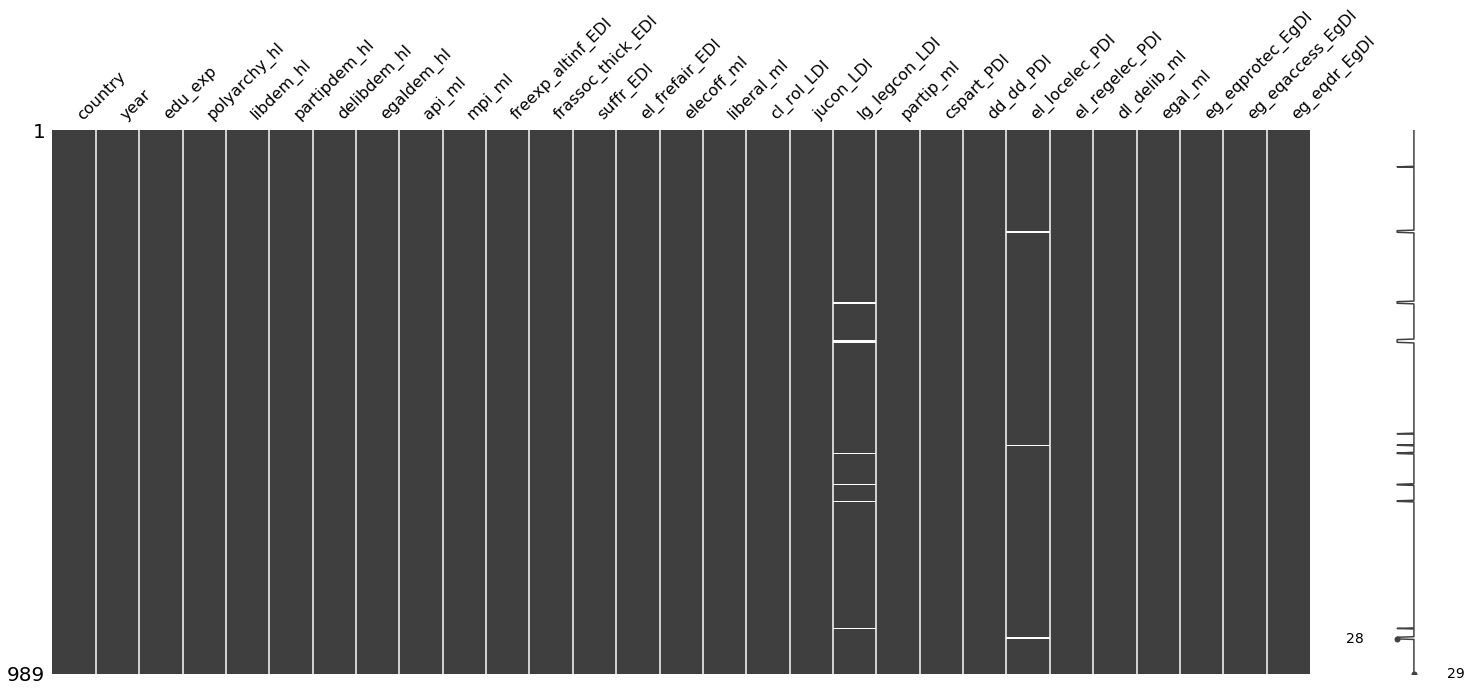

In [440]:
# check for missing data
miss.matrix(df)

Some data for lg_legcon_LDI and el_locelec_PDI is missing. Both are low-level indeces, the former is measuring to what extent are the legislature and government agencies e.g., comptroller general, general prosecutor, or ombudsman capable of questioning, investigating, and exercising oversight over the executive? And the latter is measuring whether there are elected local governments, and — if so — to what extent can they operate without interference from unelected bodies at the local level?

In [441]:
# fill missing values with mean column values
df.fillna(df.mean(), inplace=True)

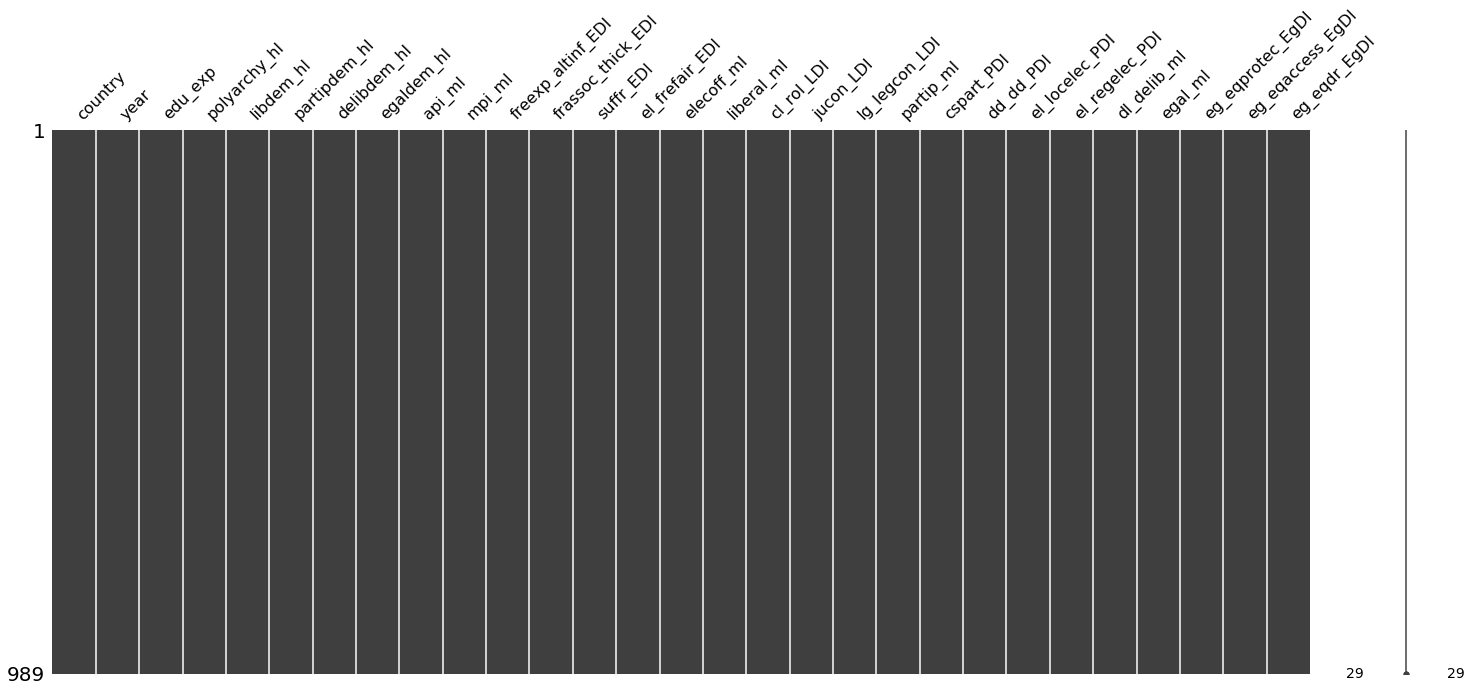

In [442]:
# check for missingness again
miss.matrix(df)

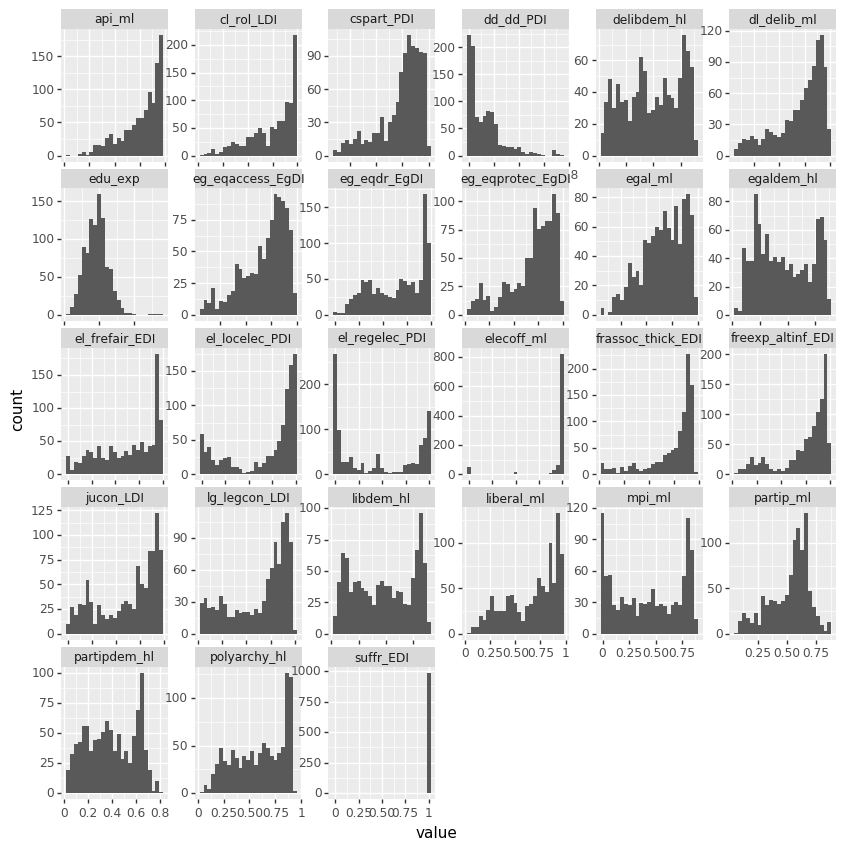

<ggplot: (-9223371938200964416)>

In [426]:
# Plot the continuous variables 
d = df.select_dtypes(include=["float64"]).melt()
(
    ggplot(d,aes(x="value")) +
    geom_histogram(bins=25) +
    facet_wrap("variable",scales='free') +
    theme(figure_size=(10,10),
          subplots_adjust={'wspace':0.25})
)

elecoff_ml (elected officials index) has almost all observations at 1 with only a few at zero, and even fewer at 0.5. This variable captures whether the chief executive and legislature are appointed through popular election, and the way it is calculated (given in the codebook) means that we can either get a value of 0, 0.5 or 1.

suffr_EDI (share of population with suffrage) is coded as 100% if there is universal suffrage and 50% if there only universal male suffrage. From the graph we can see that every country has universal suffrage. 

## Continuous Outcome Machine Learning

### Split Data

#### Start with picking only the High-Level indices as predictors.

In [769]:
y = df[['edu_exp']]
X = df[['polyarchy_hl','libdem_hl','partipdem_hl','delibdem_hl','egaldem_hl']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [770]:
print(train_X.shape[0]/df.shape[0])
print(test_X.shape[0]/df.shape[0])

0.7492416582406471
0.25075834175935285


In [771]:
# view training data
train_X.head()

,polyarchy_hl,libdem_hl,partipdem_hl,delibdem_hl,egaldem_hl
282,0.843,0.749,0.574,0.702,0.784
561,0.668,0.537,0.355,0.617,0.402
577,0.896,0.813,0.489,0.840,0.847
266,0.177,0.076,0.123,0.104,0.249
354,0.862,0.774,0.625,0.781,0.793


### Explore the training data 

In [457]:
# Look at the training data
train_X.shape 

(741, 5)

In [458]:
train_y.min()

edu_exp    0.79
dtype: float64

In [459]:
train_y.max()

edu_exp    14.06
dtype: float64

How is the data distributed?

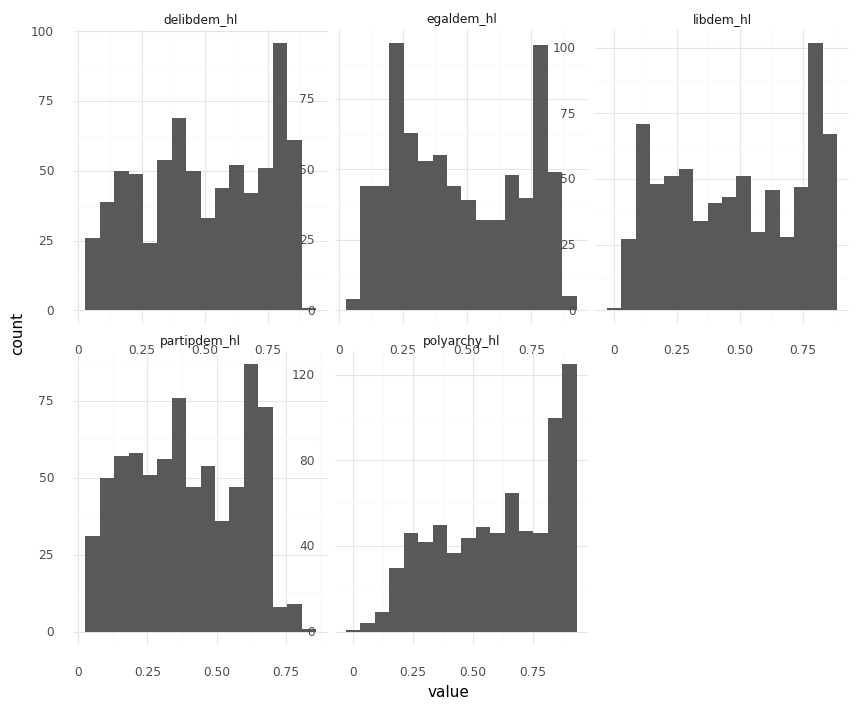

<ggplot: (-9223371938198895112)>

In [462]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All are on the same scale, and all follow a continuous distribution.

Look at the outcome `edu_exp` and see if there are any red flags. 

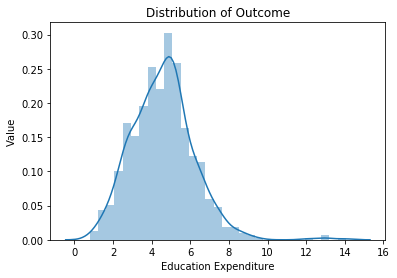

In [772]:
# Seaborn
ax = sns.distplot(train_y.edu_exp,hist=True,kde=True)
ax.set(xlabel="Education Expenditure", ylabel = "Value")
ax.set_title("Distribution of Outcome")

ax.figure.savefig("edu_exp.png")

Let's just look at how our predictors relate to the outcome.

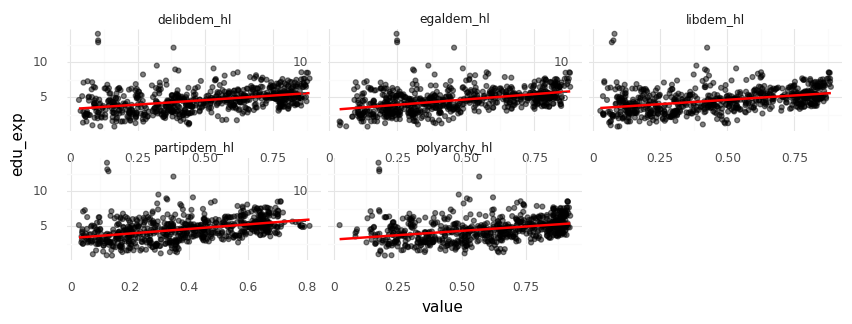

<ggplot: (-9223371938197325696)>

In [473]:
D = train_X.copy()
D['edu_exp'] = train_y

(
    ggplot(D.melt(id_vars=["edu_exp"]),
           aes(x="value",y="edu_exp"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

All our predictors seem to have a positive relationship with the outcome. This makes intuitive sense, since more democratic regimes are associated with higher education spending. However, it would be interesting to see which of these indeces matter the most in increasing education spending. 

## Train Models

### Cross Validation 

In [500]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [501]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [502]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]},
    
    # Linear Model
    {'model' : [LM()]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]}
    
]

## Run Models

Put it all together in a GridSearch

In [503]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

And Run

In [504]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]},
                         {'model': [LinearRegression()]},
                         {'model': [BaggingRegressor()]}],
             scoring='neg_mean_squared_error')

Lowest MSE:

In [505]:
search.best_score_

-1.5432274497897018

In [506]:
search.best_params_

{'model': BaggingRegressor()}

Best model: Bagging Regressor.

In [507]:
bag_mod = search.best_estimator_
bag_mod

Pipeline(steps=[('pre_process', MinMaxScaler()), ('model', BaggingRegressor())])

### Test Performance

Check how well the best performing model does on the test data that it wasn't trained on. 


In [508]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [509]:
m.mean_squared_error(test_y,pred_y)

1.2647372157258066

In [510]:
m.r2_score(test_y,pred_y)

0.524154438741822

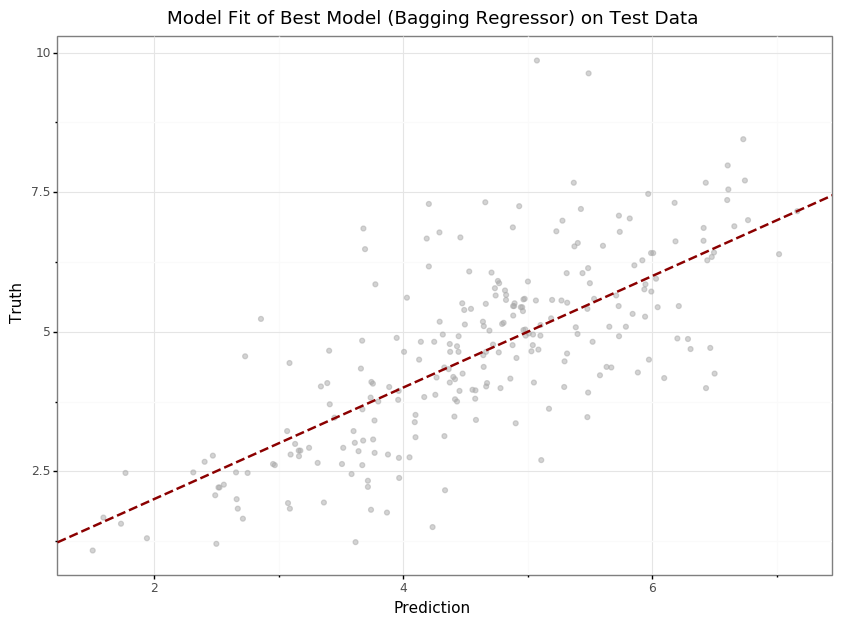

<ggplot: (-9223371938196803188)>

In [534]:
# convert test_y values to 1-dimensional array to use as input for the graph below
array_1 = test_y.values
array_test_y = array_1.flatten() 
array_test_y.shape

# plot
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=array_test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.5, color="darkgray") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    labs(x="Prediction",y="Truth",title="Model Fit of Best Model (Bagging Regressor) on Test Data")+
    theme(figure_size=(10,7))
)


# Model Interpretation

## Permutation Importance

### with `sklearn`
<br>

Examine the variable importance i.e. which variables does the model rely on most when making predictions? 

Permute the features to determine importance. Can do this 5 times for the sake of runtime, but do this 30 times.

In [537]:
vi = permutation_importance(bag_mod,train_X,train_y,n_repeats=30)

Organize the output as a data frame. 

In [539]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals (2 S.D below and above)
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# view dataframe
vi_dat

,variable,vi,std,low,high
0,egaldem_hl,2.401618,0.154351,2.092915,2.710321
1,polyarchy_hl,1.080924,0.084650,0.911624,1.250224
2,libdem_hl,0.516698,0.020209,0.476280,0.557115
3,partipdem_hl,0.408240,0.018777,0.370687,0.445793
4,delibdem_hl,0.369189,0.022016,0.325157,0.413221


Egaldem_hl by far seems to matter the most in this model, followed by polyarchy_hl. The other 3 variables matter less compared to egaldem_hl and polyarchy_hl.
<br>
egaldem_hl = Egalitarian Democracy Index (To what extent is the ideal of egalitarian democracy achieved?)
<br>
polyarchy_hl = Electoral Democracy Index (To what extent is the ideal of electoral democracy in its fullest sense achieved?)

Visualize

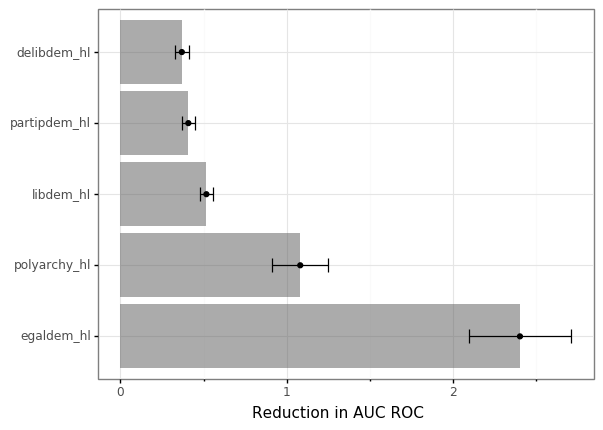

<ggplot: (-9223371938196425688)>

In [540]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Increase in MSE",x="")
)

We should be careful about analyzing these results however, since there may be multicollinearity between some variables.

### with `eli5`

Initialize the `PermutationImportance` class object. 

In [542]:
perm_train = PermutationImportance(bag_mod,
                                   n_iter=30,random_state=123)

Fit it using the train (or test!) data

In [543]:
perm_train.fit(train_X,train_y)

PermutationImportance(estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                                ('model', BaggingRegressor())]),
                      n_iter=30, random_state=123)

We can immediately extract the weights as a data frame. 

In [544]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(train_X))
vi2

,feature,weight,std
0,egaldem_hl,2.423804,0.099692
1,polyarchy_hl,1.065059,0.127109
2,libdem_hl,0.515705,0.020646
3,partipdem_hl,0.405757,0.017297
4,delibdem_hl,0.364384,0.018453


We can then just plot as we did above. 

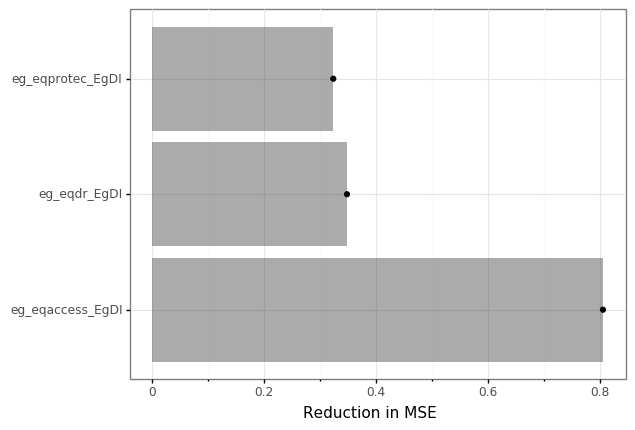

<ggplot: (-9223371938195478780)>

In [583]:
# Plot
(
    ggplot(vi2,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5) +
    geom_point() +
    theme_bw() +
    scale_x_discrete(limits=vi2.feature.tolist()) +
    coord_flip() +
    labs(y="Increase in MSE",x="")
)

### Further Exploration
Explore which one of the Low-Level indices that make up egaldem_hl is the most important? (Which of them is driving egaldem_hl?)

**egaldem_hl Egalitarian Democracy Index**

| <center> Index | <center> Tag |
| --- | --- |
| Equal protection index | eg_eqprotec_EgDI |
| Equal access index | eg_eqaccess_EgDI |
| Equal distribution of resources index | eg_eqdr_EgDI |

In [794]:
y = df[['egaldem_hl']]
X = df[['eg_eqprotec_EgDI','eg_eqaccess_EgDI','eg_eqdr_EgDI']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [795]:
print(train_X.shape[0]/df.shape[0])
print(test_X.shape[0]/df.shape[0])

0.7492416582406471
0.25075834175935285


In [552]:
# view training data
train_X.head()

,eg_eqprotec_EgDI,eg_eqaccess_EgDI,eg_eqdr_EgDI
282,0.951,0.919,0.960
561,0.653,0.776,0.311
577,0.971,0.928,0.962
266,0.775,0.815,0.920
354,0.898,0.918,0.954


### Explore the training data 

In [553]:
# Look at the training data
train_X.shape 

(741, 3)

In [554]:
train_y.min()

egaldem_hl    0.039
dtype: float64

In [555]:
train_y.max()

egaldem_hl    0.881
dtype: float64

How is the data distributed?

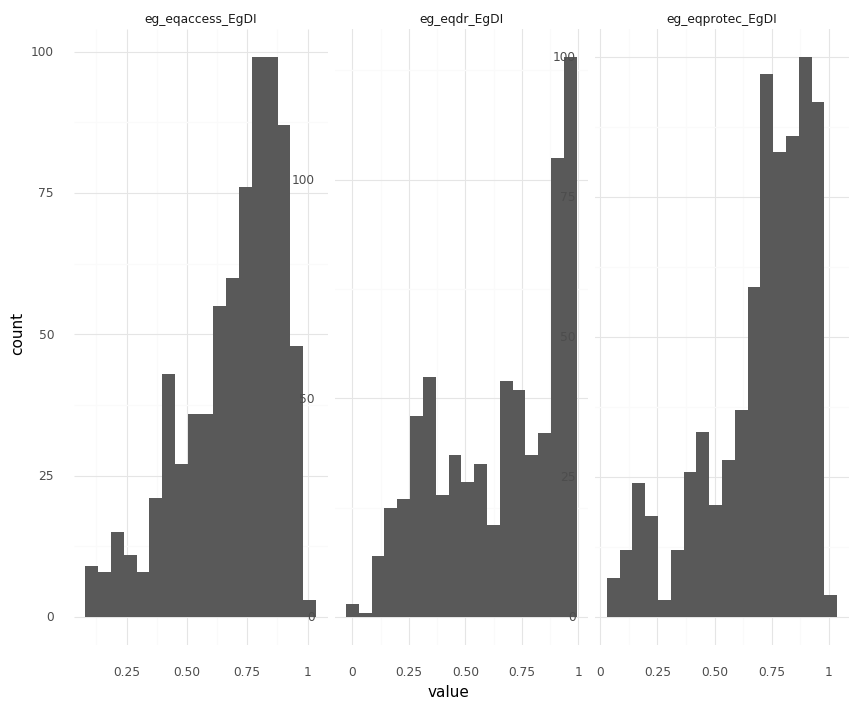

<ggplot: (-9223371938196045696)>

In [556]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All are on the same scale, and all follow a continuous distribution.

Look at the outcome `egaldem_hl` and see if there are any red flags. 

Text(0.5, 1.0, 'Distribution of Outcome')

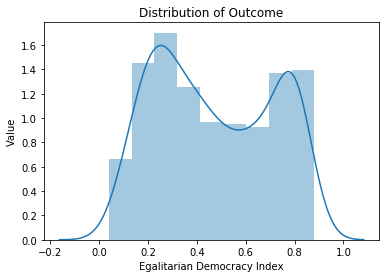

In [558]:
# Seaborn
ax = sns.distplot(train_y.egaldem_hl,hist=True,kde=True)
ax.set(xlabel="Egalitarian Democracy Index", ylabel = "Value")
ax.set_title("Distribution of Outcome")

Let's just look at how our predictors relate to the outcome.

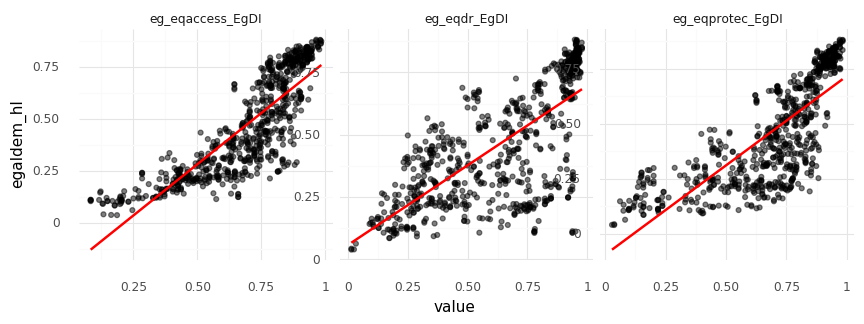

<ggplot: (-9223371938195936976)>

In [559]:
D = train_X.copy()
D['egaldem_hl'] = train_y

(
    ggplot(D.melt(id_vars=["egaldem_hl"]),
           aes(x="value",y="egaldem_hl"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

All our predictors seem to have a positive relationship with the outcome. This makes intuitive sense, however, it would be interesting to see which of these indeces matter the most in determining the Egalitarian Democracy Index. 

## Train Models

### Cross Validation 

In [796]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [797]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [798]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]},
    
    # Linear Model
    {'model' : [LM()]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]}
    
]

## Run Models

Put it all together in a GridSearch

In [799]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

And Run

In [800]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]},
                         {'model': [LinearRegression()]},
                         {'model': [BaggingRegressor()]}],
             scoring='neg_mean_squared_error')

Lowest MSE:

In [801]:
search.best_score_

-0.0037526217176480866

In [802]:
search.best_params_

{'model': BaggingRegressor()}

Best model: Bagging Regressor.

In [803]:
bag_mod = search.best_estimator_
bag_mod

Pipeline(steps=[('pre_process', MinMaxScaler()), ('model', BaggingRegressor())])

### Test Performance

Check how well the best performing model does on the test data that it wasn't trained on. 


In [804]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [805]:
m.mean_squared_error(test_y,pred_y)

0.0036417405525570657

In [806]:
m.r2_score(test_y,pred_y)

0.9420516331684439

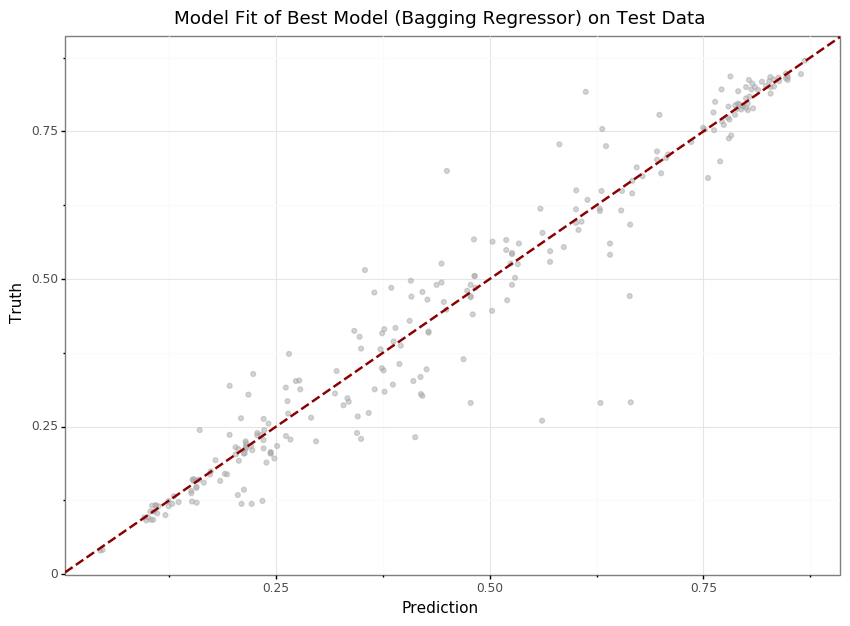

<ggplot: (-9223371938195558876)>

In [575]:
# convert test_y values to 1-dimensional array to use as input for the graph below
array_1 = test_y.values
array_test_y = array_1.flatten() 
array_test_y.shape

# plot
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=array_test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.5, color="darkgray") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    labs(x="Prediction",y="Truth",title="Model Fit of Best Model (Bagging Regressor) on Test Data")+
    theme(figure_size=(10,7))
)

# Model Interpretation

## Permutation Importance

### with `sklearn`
<br>

Examine the variable importance i.e. which variables does the model rely on most when making predictions? 

Permute the features to determine importance. Can do this 5 times for the sake of runtime, but I'll do this 30 times.

In [807]:
vi = permutation_importance(bag_mod,train_X,train_y,n_repeats=30)

Organize the output as a data frame. 

In [808]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals (2 S.D below and above)
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# view dataframe
vi_dat

,variable,vi,std,low,high
0,eg_eqaccess_EgDI,0.763948,0.038142,0.687665,0.840231
1,eg_eqprotec_EgDI,0.425021,0.022519,0.379983,0.470059
2,eg_eqdr_EgDI,0.337087,0.016348,0.304391,0.369783


`eg_eqaccess_EgDI`by far seems to matter the most in this model, followed by `eg_eqdr_EgDI` and `eg_eqprotec_EgDI`.
<br>
<br>
`eg_eqaccess_EgDI` = Equal Access Index (How equal is access to power?)
<br>
The Equal Access subcomponent is based on the idea that neither the protections of rights and freedoms nor the equal distribution of resources is sufficient to ensure adequate representation. Ideally, all groups should enjoy equal de facto capabilities to participate, to serve in positions of political power, to put issues on the agenda, and to influence policymaking.

`eg_eqdr_EgDI` = Equal distribution of resources index (How equal is the distribution of resources?)
<br>
This component measures the extent to which resources — both tangible and intangible — are distributed in society. An equal distribution of resources supports egalitarian democracy in two ways. First, lower poverty rates and the distribution of goods and services such as food, water, housing, education and healthcare ensure that all individuals are capable of participating in politics and government. In short, basic needs must be met in order for individuals to effectively exercise their rights and freedoms see, for example, Sen 1999, Maslow 1943. Second, high levels of resource inequality undermine the ability of poorer populations to participate meaningfully Aristotle, Dahl 2006. Thus, it is necessary to include not only measures of poverty and the distribution of goods and services, but also the levels of inequality in these distributions, and the proportion of the population who are not eligible for social services i.e. means-tests, particularistic distribution, etc.. This principle also implies that social or economic inequalities can translate into political inequalities, an issue addressed most notably by Walzer 1983, who argues that overlapping "spheres" of inequality are particularly harmful to society. To address these overlapping "spheres", this component also includes measures of the distribution of power in society amongst different socio-economic groups, genders, etc.

`eg_eqprotec_EgDI` = Equal protection index (How equal is the protection of rights and freedoms across social groups by the state?)
<br>
Equal protection means that the state grants and protects rights and freedoms evenly across social groups. To achieve equal protection of rights and freedoms, the state itself must not interfere in the ability of groups to participate and it must also take action to ensure that rights and freedoms of one social group are not threatened by the actions of another group or individual.

Visualize

In [825]:
# Plot
myplot2=(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.4, fill="orange") +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),color = "tomato",width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Increase in MSE",x="")
)

# save plot
myplot2.save("vi_FE.png", dpi =300)

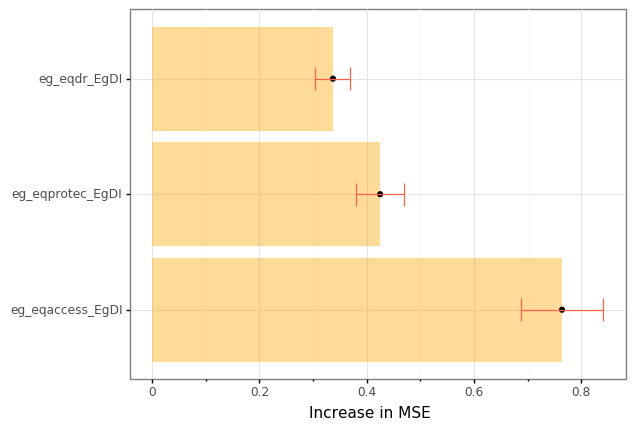

<ggplot: (-9223371938203106852)>

In [826]:
# view plot
myplot2

We should be careful about analyzing these results however, since there may be multicollinearity between some variables.

### with `eli5`

Initialize the `PermutationImportance` class object. 

In [579]:
perm_train = PermutationImportance(bag_mod,
                                   n_iter=30,random_state=123)

Fit it using the train (or test!) data

In [580]:
perm_train.fit(train_X,train_y)

PermutationImportance(estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                                ('model', BaggingRegressor())]),
                      n_iter=30, random_state=123)

We can immediately extract the weights as a data frame. 

In [581]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(train_X))
vi2

,feature,weight,std
0,eg_eqaccess_EgDI,0.805479,0.039837
1,eg_eqdr_EgDI,0.348225,0.015589
2,eg_eqprotec_EgDI,0.323774,0.012542


We can then just plot as we did above. 

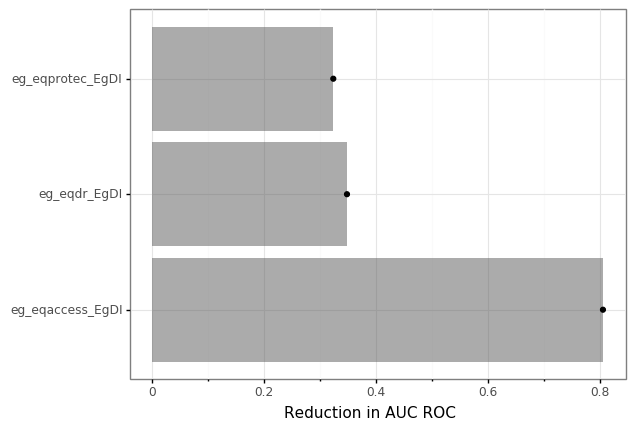

<ggplot: (-9223371938195551032)>

In [582]:
# Plot
(
    ggplot(vi2,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5) +
    geom_point() +
    theme_bw() +
    scale_x_discrete(limits=vi2.feature.tolist()) +
    coord_flip() +
    labs(y="Increase in MSE",x="")
)

## Second Machine Learning Model
outcome = difference in education expenditure.

In [633]:
# create copy of df
df1 = df.copy()

In [634]:
df1.head()

,country,year,edu_exp,polyarchy_hl,libdem_hl,partipdem_hl,delibdem_hl,egaldem_hl,api_ml,mpi_ml,...,partip_ml,cspart_PDI,dd_dd_PDI,el_locelec_PDI,el_regelec_PDI,dl_delib_ml,egal_ml,eg_eqprotec_EgDI,eg_eqaccess_EgDI,eg_eqdr_EgDI
0,afghanistan,2010,3.48,0.362,0.238,0.156,0.319,0.215,0.643,0.087,...,0.297,0.656,0.02,0.007,0.190,0.776,0.467,0.537,0.547,0.405
1,afghanistan,2011,3.46,0.369,0.241,0.158,0.314,0.223,0.653,0.085,...,0.297,0.656,0.02,0.007,0.190,0.760,0.467,0.537,0.547,0.405
2,afghanistan,2012,2.60,0.371,0.242,0.160,0.352,0.228,0.643,0.104,...,0.297,0.656,0.02,0.007,0.190,0.807,0.467,0.537,0.547,0.405
3,afghanistan,2013,3.45,0.362,0.232,0.152,0.313,0.225,0.637,0.094,...,0.285,0.680,0.02,0.106,0.134,0.754,0.504,0.536,0.575,0.344
4,afghanistan,2014,3.70,0.403,0.262,0.164,0.354,0.239,0.666,0.138,...,0.285,0.680,0.02,0.106,0.134,0.753,0.483,0.498,0.575,0.323


In [635]:
# create new column that calculates the difference between edu_exp by country-year.

df1.set_index(['country','year'], inplace=True)
df1.sort_index(inplace=True)
df1['edu_exp_diff'] = np.nan 

for idx in df1.index.levels[0]:
    df1.edu_exp_diff[idx] = df1.edu_exp[idx].diff()

In [827]:
df1.head()

edu_exp  polyarchy_hl  libdem_hl  partipdem_hl  delibdem_hl  \
country     year                                                                
afghanistan 2010     3.48         0.362      0.238         0.156        0.319   
            2011     3.46         0.369      0.241         0.158        0.314   
            2012     2.60         0.371      0.242         0.160        0.352   
            2013     3.45         0.362      0.232         0.152        0.313   
            2014     3.70         0.403      0.262         0.164        0.354   

                  egaldem_hl  api_ml  mpi_ml  freexp_altinf_EDI  \
country     year                                                  
afghanistan 2010       0.215   0.643   0.087              0.681   
            2011       0.223   0.653   0.085              0.681   
            2012       0.228   0.643   0.104              0.690   
            2013       0.225   0.637   0.094              0.679   
            2014       0.239   0.666   0.138              0.657   

                  frassoc_thick_EDI  ...  cspart_PDI  dd_dd_PDI  \
country     year                     ...                          
afghanistan 2010              0.723  ...       0.656       0.02   
            2011              0.687  ...       0.656       0.02   
            2012              0.732  ...       0.656       0.02   
            2013              0.687  ...       0.680       0.02   
            2014              0.675  ...       0.680       0.02   

                  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  egal_ml  \
country     year                                                         
afghanistan 2010           0.007           0.190        0.776    0.467   
            2011           0.007           0.190        0.760    0.467   
            2012           0.007           0.190        0.807    0.467   
            2013           0.106           0.134        0.754    0.504   
            2014           0.106           0.134        0.753    0.483   

                  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  \
country     year                                                     
afghanistan 2010             0.537             0.547         0.405   
            2011             0.537             0.547         0.405   
            2012             0.537             0.547         0.405   
            2013             0.536             0.575         0.344   
            2014             0.498             0.575         0.323   

                  edu_exp_diff  
country     year                
afghanistan 2010          0.00  
            2011         -0.02  
            2012         -0.86  
            2013          0.85  
            2014          0.25  

[5 rows x 28 columns]

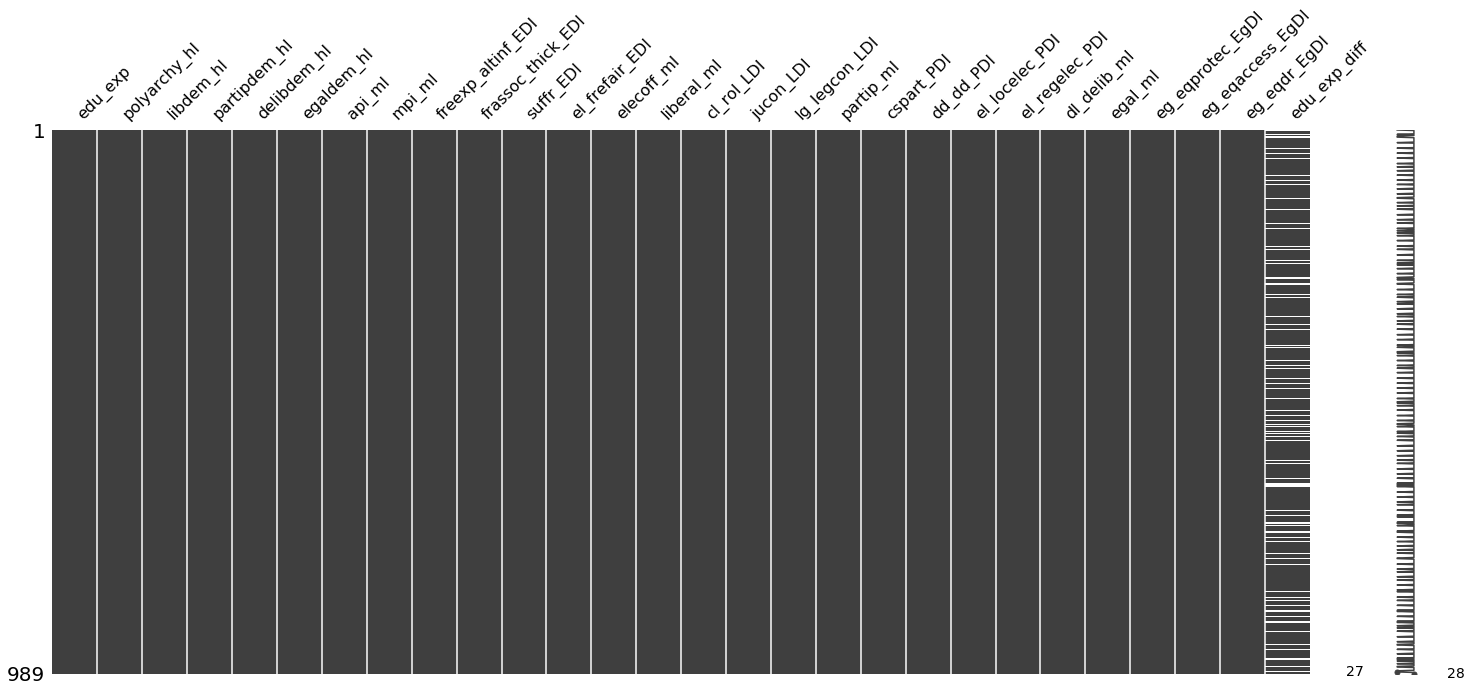

In [656]:
# check for missingness
miss.matrix(df1)

The missing data is the value of edu_exp_diff in the first year of every country. Since there's no previous year to compare that value with, it is coded as nan. Let's replace all the missing values with 0.  

In [657]:
df1['edu_exp_diff'] = df1['edu_exp_diff'].replace(np.nan, 0)

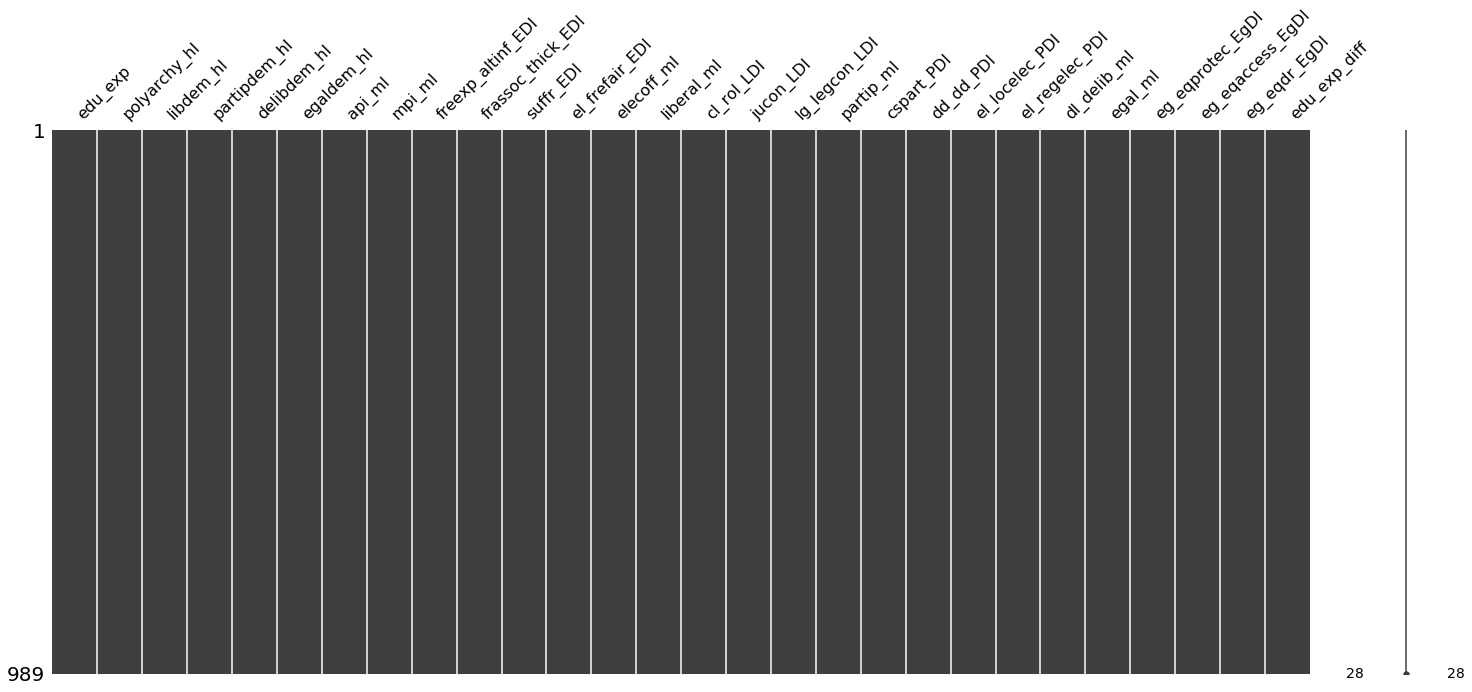

In [659]:
# check for missingness again
miss.matrix(df1)

### Split Data

#### Start with picking only the High-Level indices as predictors.

In [828]:
y = df1[['edu_exp_diff']]
X = df1[['polyarchy_hl','libdem_hl','partipdem_hl','delibdem_hl','egaldem_hl']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [661]:
print(train_X.shape[0]/df1.shape[0])
print(test_X.shape[0]/df1.shape[0])

0.7492416582406471
0.25075834175935285


In [662]:
# view training data
train_X.head()

,,polyarchy_hl,libdem_hl,partipdem_hl,delibdem_hl,egaldem_hl
country,year,,,,,
czech-republic,2015,0.843,0.749,0.574,0.702,0.784
liberia,2008,0.668,0.537,0.355,0.617,0.402
luxembourg,2014,0.896,0.813,0.489,0.840,0.847
cuba,2009,0.177,0.076,0.123,0.104,0.249
france,2013,0.862,0.774,0.625,0.781,0.793


### Explore the training data 

In [663]:
# Look at the training data
train_X.shape 

(741, 5)

In [664]:
train_y.min()

edu_exp_diff   -3.31
dtype: float64

In [665]:
train_y.max()

edu_exp_diff    4.53
dtype: float64

How is the data distributed?

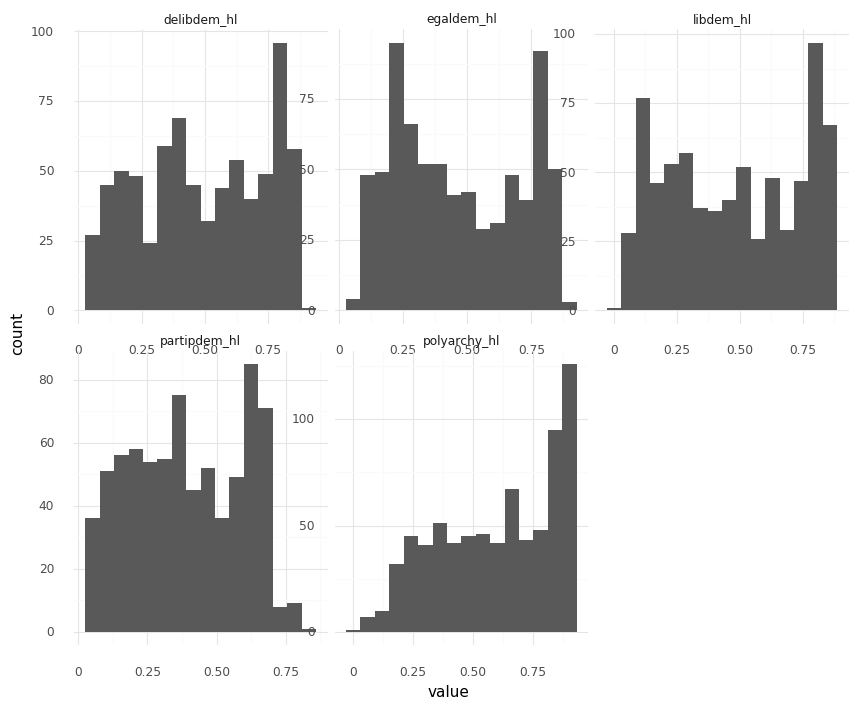

<ggplot: (-9223371938202725248)>

In [666]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All are on the same scale, and all follow a continuous distribution.

Look at the outcome `edu_exp_diff` and see if there are any red flags. 

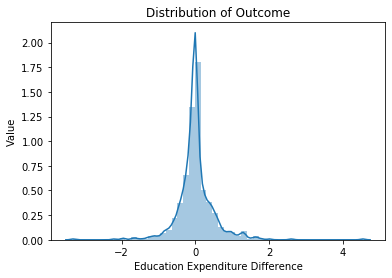

In [830]:
# Seaborn
ax = sns.distplot(train_y.edu_exp_diff,hist=True,kde=True)
ax.set(xlabel="Education Expenditure Difference", ylabel = "Value")
ax.set_title("Distribution of Outcome")

ax.figure.savefig("edu_exp_diff.png")

Let's just look at how our predictors relate to the outcome.

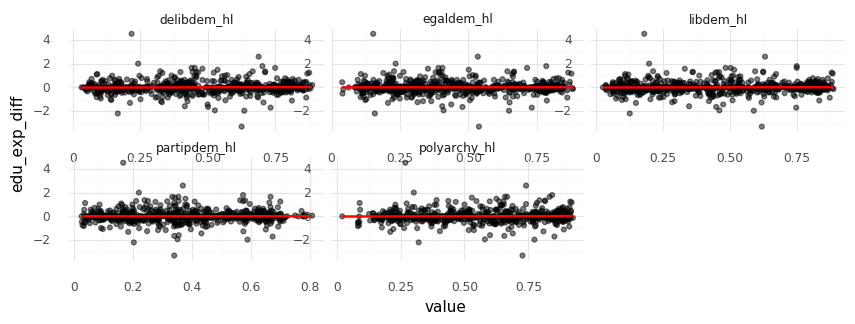

<ggplot: (-9223371938202095896)>

In [668]:
D = train_X.copy()
D['edu_exp_diff'] = train_y

(
    ggplot(D.melt(id_vars=["edu_exp_diff"]),
           aes(x="value",y="edu_exp_diff"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

All our predictors seem to have close to no relationship with the outcome. Let's see if any of these indeces matter the most for a change in education spending. 

## Train Models

### Cross Validation 

In [669]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [670]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [671]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]},
    
    # Linear Model
    {'model' : [LM()]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]}
    
]

## Run Models

Put it all together in a GridSearch

In [672]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

And Run

In [673]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestRegressor(max_depth=2,
                                                          n_estimators=500)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]},
                         {'model': [LinearRegression()]},
                         {'model': [BaggingRegressor()]}],
             scoring='neg_mean_squared_error')

Lowest MSE:

In [674]:
search.best_score_

-0.26420152572693645

In [675]:
search.best_params_

{'model': RandomForestRegressor(max_depth=2, n_estimators=500),
 'model__max_depth': 2,
 'model__n_estimators': 500}

Best model: Random Forest. Trees with a depth of 2, and we spanned across 500 trees.

In [676]:
rf_mod = search.best_estimator_
rf_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestRegressor(max_depth=2, n_estimators=500))])

### Test Performance

Check how well the best performing model does on the test data that it wasn't trained on. 


In [678]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [679]:
m.mean_squared_error(test_y,pred_y)

0.2912038041907737

In [682]:
m.r2_score(test_y,pred_y)

-0.05160051781088226

A negative R-squared means that our prediction is less accurate than the average value of the data set over time. 

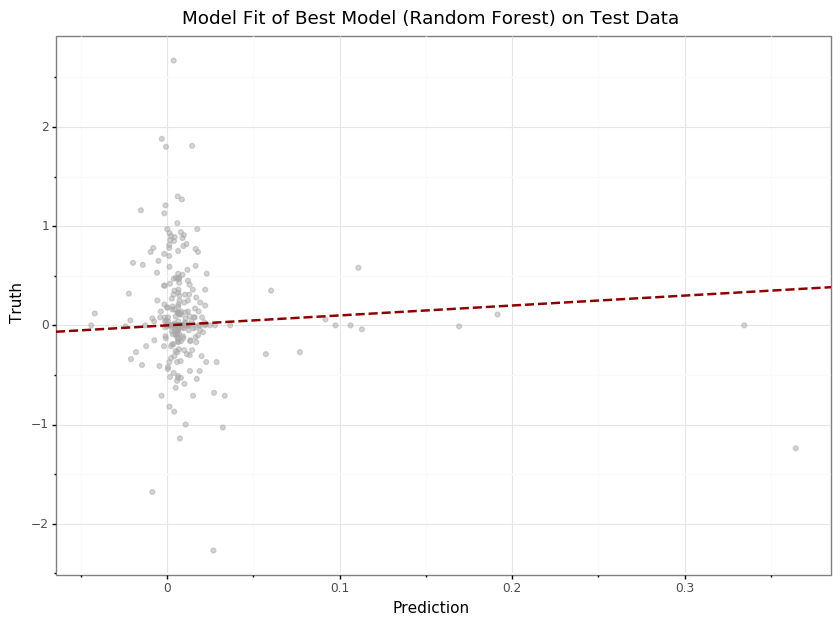

<ggplot: (-9223371938202087636)>

In [684]:
# convert test_y values to 1-dimensional array to use as input for the graph below
array_1 = test_y.values
array_test_y = array_1.flatten() 
array_test_y.shape

# plot
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=array_test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.5, color="darkgray") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    labs(x="Prediction",y="Truth",title="Model Fit of Best Model (Random Forest) on Test Data")+
    theme(figure_size=(10,7))
)

### Split Data

#### Running Model with only low-level indices. 

In [686]:
y = df1[['edu_exp_diff']]
X = df1[['freexp_altinf_EDI', 'frassoc_thick_EDI', 'suffr_EDI', 'el_frefair_EDI', 'cl_rol_LDI',
         'jucon_LDI', 'lg_legcon_LDI', 'cspart_PDI', 'dd_dd_PDI', 'el_locelec_PDI', 'el_regelec_PDI',
         'eg_eqprotec_EgDI', 'eg_eqaccess_EgDI', 'eg_eqdr_EgDI']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [687]:
print(train_X.shape[0]/df1.shape[0])
print(test_X.shape[0]/df1.shape[0])

0.7492416582406471
0.25075834175935285


In [690]:
# view training data
train_X.head()

,,freexp_altinf_EDI,frassoc_thick_EDI,suffr_EDI,el_frefair_EDI,cl_rol_LDI,jucon_LDI,lg_legcon_LDI,cspart_PDI,dd_dd_PDI,el_locelec_PDI,el_regelec_PDI,eg_eqprotec_EgDI,eg_eqaccess_EgDI,eg_eqdr_EgDI
country,year,,,,,,,,,,,,,,
czech-republic,2015,0.920,0.890,1.0,0.953,0.967,0.879,0.874,0.840,0.068,0.931,0.971,0.951,0.919,0.960
liberia,2008,0.921,0.864,1.0,0.665,0.821,0.702,0.802,0.905,0.007,0.420,0.000,0.653,0.776,0.311
luxembourg,2014,0.951,0.899,1.0,0.963,0.971,0.822,0.901,0.950,0.163,0.190,0.000,0.971,0.928,0.962
cuba,2009,0.081,0.046,1.0,0.266,0.275,0.208,0.083,0.181,0.033,0.828,0.906,0.775,0.815,0.920
france,2013,0.961,0.909,1.0,0.943,0.966,0.903,0.861,0.915,0.113,0.972,0.954,0.898,0.918,0.954


### Explore the training data 

In [691]:
# Look at the training data
train_X.shape 

(741, 14)

In [692]:
train_y.min()

edu_exp_diff   -3.31
dtype: float64

In [693]:
train_y.max()

edu_exp_diff    4.53
dtype: float64

How is the data distributed?

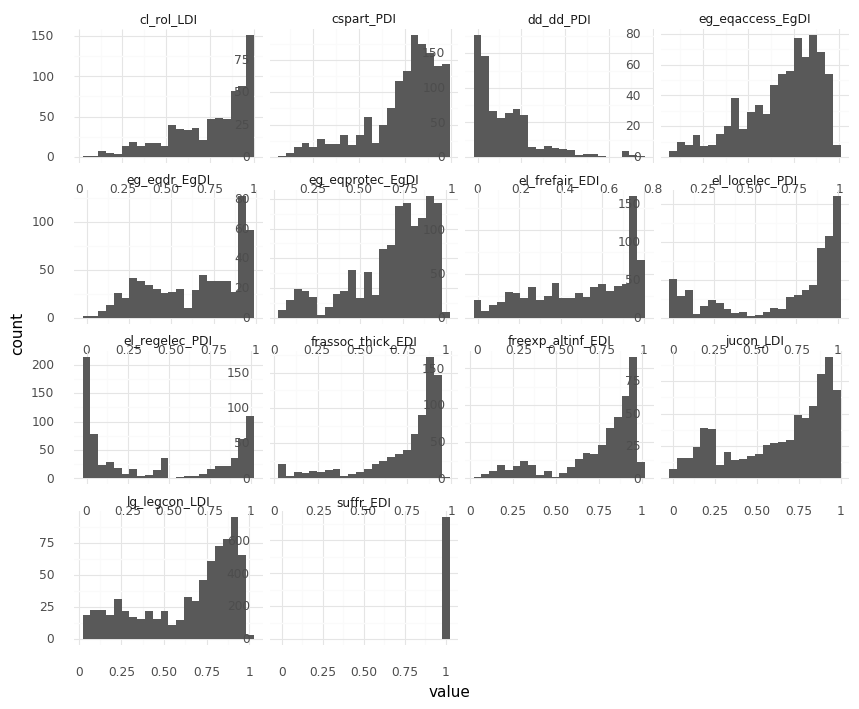

<ggplot: (-9223371938195318396)>

In [694]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All are on the same scale, and all follow a continuous distribution.

Look at the outcome `edu_exp_diff` and see if there are any red flags. 

Text(0.5, 1.0, 'Distribution of Outcome')

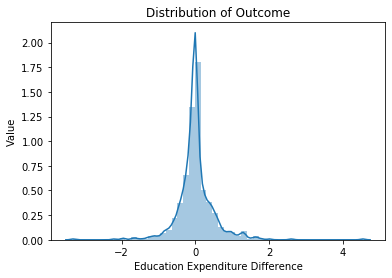

In [695]:
# Seaborn
ax = sns.distplot(train_y.edu_exp_diff,hist=True,kde=True)
ax.set(xlabel="Education Expenditure Difference", ylabel = "Value")
ax.set_title("Distribution of Outcome")

Let's just look at how our predictors relate to the outcome.

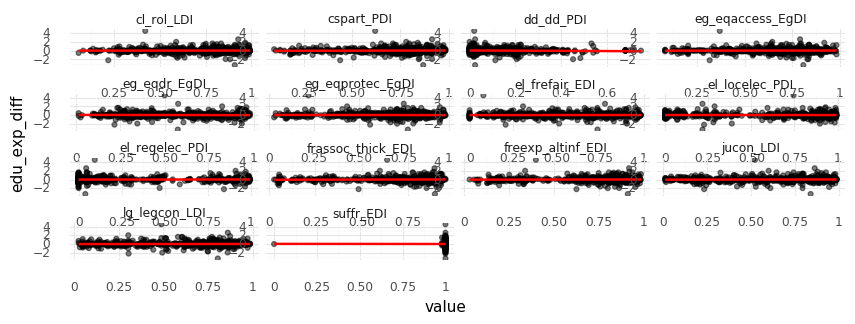

<ggplot: (-9223371938201228524)>

In [696]:
D = train_X.copy()
D['edu_exp_diff'] = train_y

(
    ggplot(D.melt(id_vars=["edu_exp_diff"]),
           aes(x="value",y="edu_exp_diff"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

All our predictors seem to have close to no relationship with the outcome. Let's see if any of these indeces matter the most for a change in education spending. 

## Train Models

### Cross Validation 

In [697]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [698]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [699]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]},
    
    # Linear Model
    {'model' : [LM()]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]}
    
]

## Run Models

Put it all together in a GridSearch

In [700]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

And Run

In [701]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestRegressor(max_depth=2,
                                                          n_estimators=500)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]},
                         {'model': [LinearRegression()]},
                         {'model': [BaggingRegressor()]}],
             scoring='neg_mean_squared_error')

Lowest MSE:

In [702]:
search.best_score_

-0.2673515616550845

In [703]:
search.best_params_

{'model': RandomForestRegressor(max_depth=2, n_estimators=500),
 'model__max_depth': 2,
 'model__n_estimators': 500}

Best model: Random Forest. Trees with a depth of 2, and we spanned across 500 trees.

In [704]:
rf_mod = search.best_estimator_
rf_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model',
                 RandomForestRegressor(max_depth=2, n_estimators=500))])

### Test Performance

Check how well the best performing model does on the test data that it wasn't trained on. 


In [705]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [706]:
m.mean_squared_error(test_y,pred_y)

0.29404329094738835

In [707]:
m.r2_score(test_y,pred_y)

-0.06185452445708983

A negative R-squared means that our prediction is less accurate than the average value of the data set over time. 

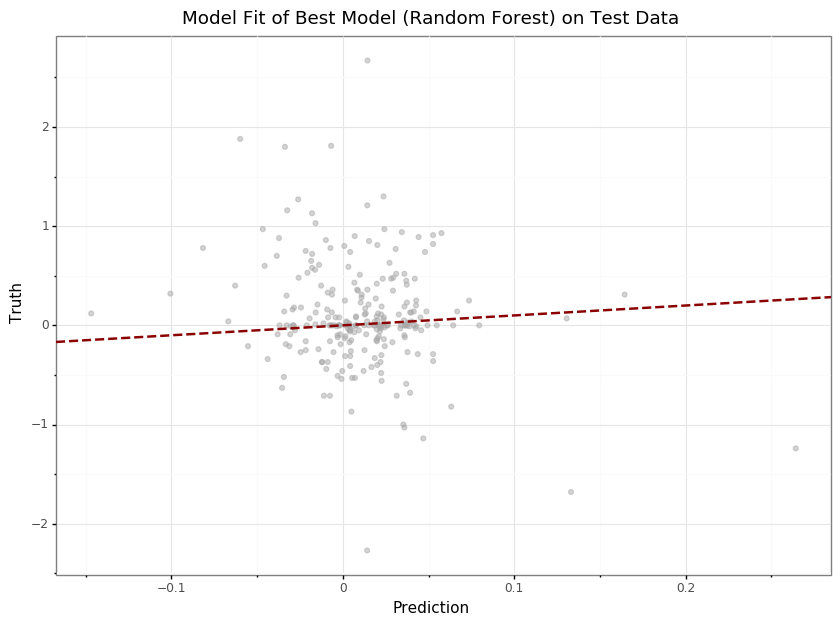

<ggplot: (-9223371938202015680)>

In [708]:
# convert test_y values to 1-dimensional array to use as input for the graph below
array_1 = test_y.values
array_test_y = array_1.flatten() 
array_test_y.shape

# plot
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=array_test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.5, color="darkgray") +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    labs(x="Prediction",y="Truth",title="Model Fit of Best Model (Random Forest) on Test Data")+
    theme(figure_size=(10,7))
)

It makes sense that we get the same result, since the low-level indices make up the high-level indices. 

## Third Machine Learning Model
outcome = increase in education expenditure.

In [709]:
# create copy of df
df2 = df.copy()

In [710]:
df2.head()

,country,year,edu_exp,polyarchy_hl,libdem_hl,partipdem_hl,delibdem_hl,egaldem_hl,api_ml,mpi_ml,...,partip_ml,cspart_PDI,dd_dd_PDI,el_locelec_PDI,el_regelec_PDI,dl_delib_ml,egal_ml,eg_eqprotec_EgDI,eg_eqaccess_EgDI,eg_eqdr_EgDI
0,afghanistan,2010,3.48,0.362,0.238,0.156,0.319,0.215,0.643,0.087,...,0.297,0.656,0.02,0.007,0.190,0.776,0.467,0.537,0.547,0.405
1,afghanistan,2011,3.46,0.369,0.241,0.158,0.314,0.223,0.653,0.085,...,0.297,0.656,0.02,0.007,0.190,0.760,0.467,0.537,0.547,0.405
2,afghanistan,2012,2.60,0.371,0.242,0.160,0.352,0.228,0.643,0.104,...,0.297,0.656,0.02,0.007,0.190,0.807,0.467,0.537,0.547,0.405
3,afghanistan,2013,3.45,0.362,0.232,0.152,0.313,0.225,0.637,0.094,...,0.285,0.680,0.02,0.106,0.134,0.754,0.504,0.536,0.575,0.344
4,afghanistan,2014,3.70,0.403,0.262,0.164,0.354,0.239,0.666,0.138,...,0.285,0.680,0.02,0.106,0.134,0.753,0.483,0.498,0.575,0.323


In [711]:
# create new column that calculates the difference between edu_exp by country-year.

df2.set_index(['country','year'], inplace=True)
df2.sort_index(inplace=True)
df2['edu_exp_diff'] = np.nan 

for idx in df2.index.levels[0]:
    df2.edu_exp_diff[idx] = df2.edu_exp[idx].diff()

In [716]:
# replace missing values with 0
df2['edu_exp_diff'] = df2['edu_exp_diff'].replace(np.nan, 0)

# set increase (positive number) to 1, decrease/no change to 0
df2['edu_exp_diff'][df2['edu_exp_diff'] <= 0] = 0
df2['edu_exp_diff'][df2['edu_exp_diff'] > 0] = 1

In [718]:
# rename column
df2.rename(columns={'edu_exp_diff': 'edu_exp_increase'}, inplace=True)

In [719]:
df2.head()

edu_exp  polyarchy_hl  libdem_hl  partipdem_hl  delibdem_hl  \
country     year                                                                
afghanistan 2010     3.48         0.362      0.238         0.156        0.319   
            2011     3.46         0.369      0.241         0.158        0.314   
            2012     2.60         0.371      0.242         0.160        0.352   
            2013     3.45         0.362      0.232         0.152        0.313   
            2014     3.70         0.403      0.262         0.164        0.354   

                  egaldem_hl  api_ml  mpi_ml  freexp_altinf_EDI  \
country     year                                                  
afghanistan 2010       0.215   0.643   0.087              0.681   
            2011       0.223   0.653   0.085              0.681   
            2012       0.228   0.643   0.104              0.690   
            2013       0.225   0.637   0.094              0.679   
            2014       0.239   0.666   0.138              0.657   

                  frassoc_thick_EDI  ...  cspart_PDI  dd_dd_PDI  \
country     year                     ...                          
afghanistan 2010              0.723  ...       0.656       0.02   
            2011              0.687  ...       0.656       0.02   
            2012              0.732  ...       0.656       0.02   
            2013              0.687  ...       0.680       0.02   
            2014              0.675  ...       0.680       0.02   

                  el_locelec_PDI  el_regelec_PDI  dl_delib_ml  egal_ml  \
country     year                                                         
afghanistan 2010           0.007           0.190        0.776    0.467   
            2011           0.007           0.190        0.760    0.467   
            2012           0.007           0.190        0.807    0.467   
            2013           0.106           0.134        0.754    0.504   
            2014           0.106           0.134        0.753    0.483   

                  eg_eqprotec_EgDI  eg_eqaccess_EgDI  eg_eqdr_EgDI  \
country     year                                                     
afghanistan 2010             0.537             0.547         0.405   
            2011             0.537             0.547         0.405   
            2012             0.537             0.547         0.405   
            2013             0.536             0.575         0.344   
            2014             0.498             0.575         0.323   

                  edu_exp_increase  
country     year                    
afghanistan 2010               0.0  
            2011               0.0  
            2012               0.0  
            2013               1.0  
            2014               1.0  

[5 rows x 28 columns]

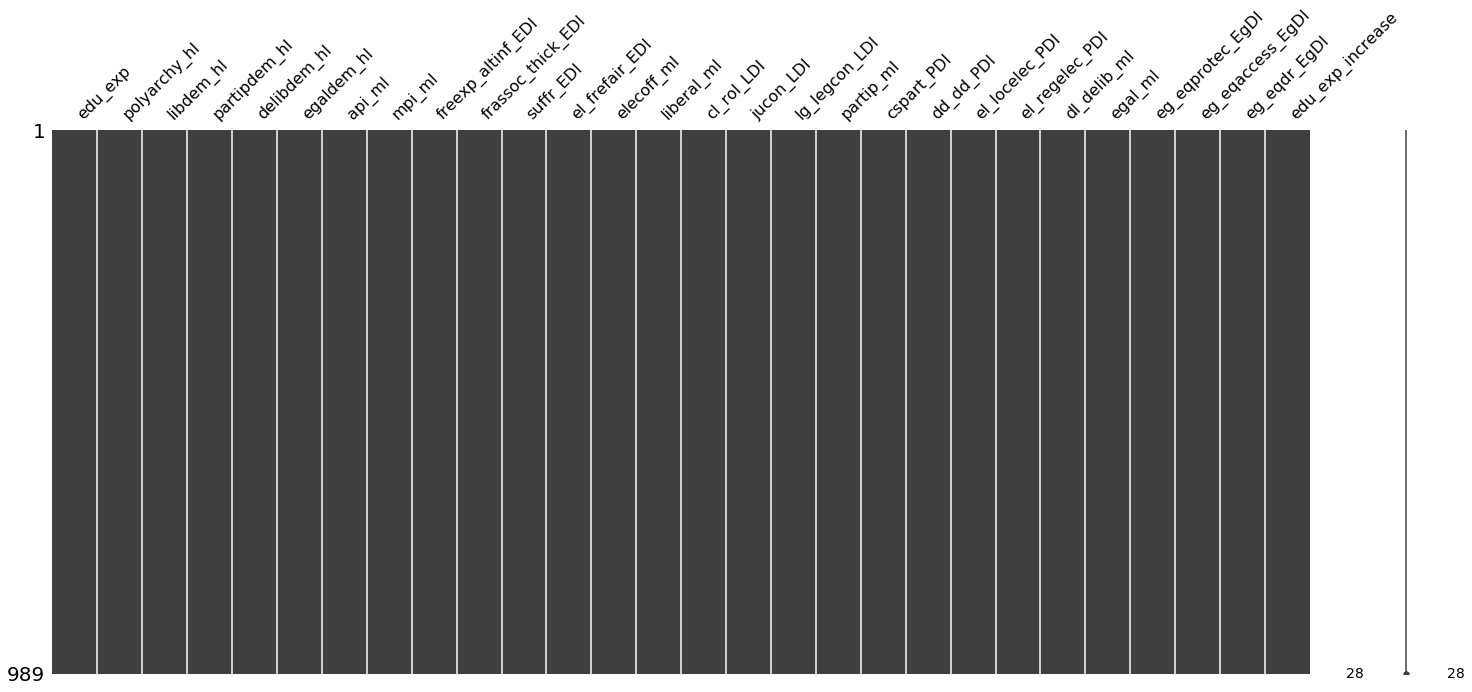

In [720]:
# check for missingness
miss.matrix(df2)

### Split Data

#### Start with picking only the High-Level indices as predictors.

In [773]:
y = df2[['edu_exp_increase']]
X = df2[['polyarchy_hl','libdem_hl','partipdem_hl','delibdem_hl','egaldem_hl']]
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [774]:
print(train_X.shape[0]/df2.shape[0])
print(test_X.shape[0]/df2.shape[0])

0.7492416582406471
0.25075834175935285


In [775]:
# view training data
train_X.head()

,,polyarchy_hl,libdem_hl,partipdem_hl,delibdem_hl,egaldem_hl
country,year,,,,,
czech-republic,2015,0.843,0.749,0.574,0.702,0.784
liberia,2008,0.668,0.537,0.355,0.617,0.402
luxembourg,2014,0.896,0.813,0.489,0.840,0.847
cuba,2009,0.177,0.076,0.123,0.104,0.249
france,2013,0.862,0.774,0.625,0.781,0.793


### Explore the training data 

In [726]:
# Look at the training data
train_X.shape 

(741, 5)

In [776]:
train_y.min()

edu_exp_increase    0.0
dtype: float64

In [777]:
train_y.max()

edu_exp_increase    1.0
dtype: float64

How is the data distributed?

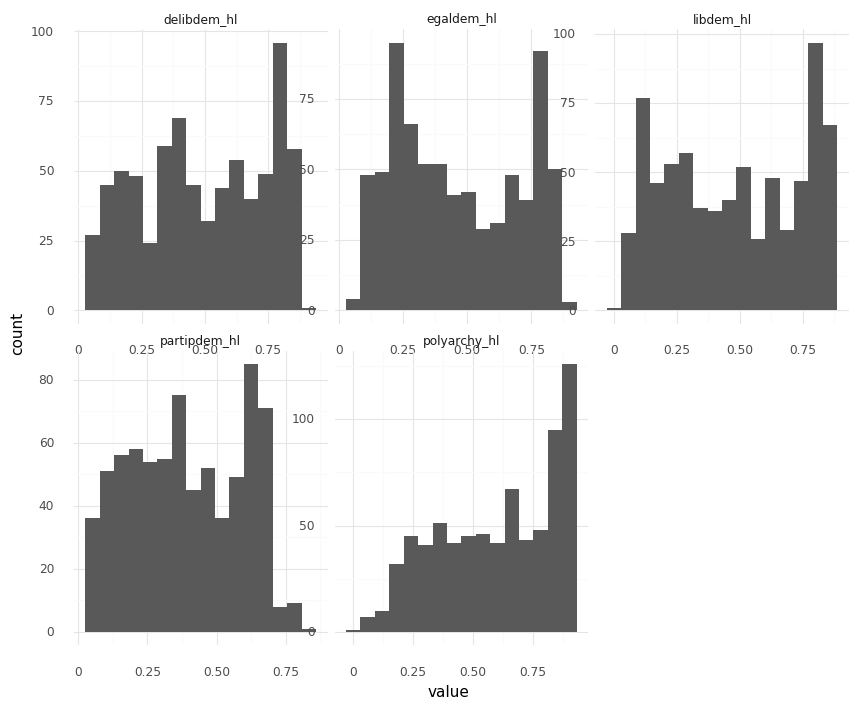

<ggplot: (-9223371938202725248)>

In [666]:
(
    ggplot(train_X.melt(),aes(x="value")) +
    geom_histogram() +
    facet_wrap("variable",scales="free") +
    theme_minimal() +
    theme(figure_size = (10,8)) 
) 

Insights:
- All are on the same scale, and all follow a continuous distribution.

Look at the outcome `edu_exp_increase` and see if there are any red flags. 

Text(0.5, 1.0, 'Distribution of Outcome')

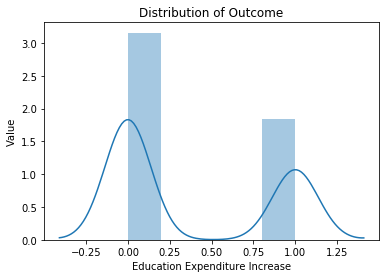

In [778]:
# Seaborn
ax = sns.distplot(train_y.edu_exp_increase,hist=True,kde=True)
ax.set(xlabel="Education Expenditure Increase", ylabel = "Value")
ax.set_title("Distribution of Outcome")

Let's just look at how our predictors relate to the outcome.

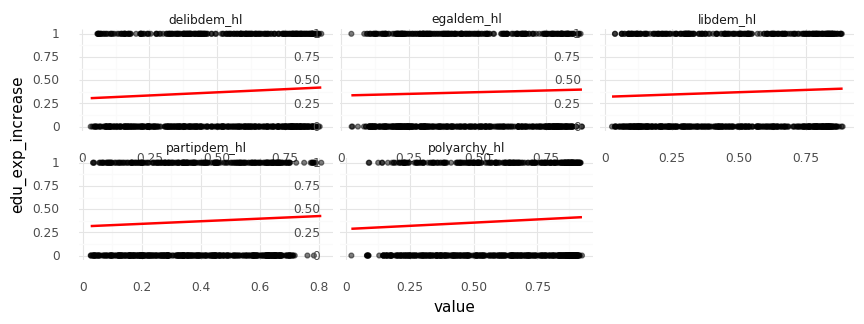

<ggplot: (-9223371938199694948)>

In [731]:
D = train_X.copy()
D['edu_exp_increase'] = train_y

(
    ggplot(D.melt(id_vars=["edu_exp_increase"]),
           aes(x="value",y="edu_exp_increase"))+
    geom_point(alpha=.5) +
    facet_wrap("variable",scales="free") +
    geom_smooth(method="lm",se=False,color="red") +
    theme_minimal() +
    theme(figure_size = (10,3)) 
)

All our predictors seem to have close a fairly positive relationship with the outcome. Let's see which one of these indeces matter the most for an increase in education spending. 

## Train Models

### Cross Validation 

In [779]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=202011)

## Initialize Pipeline

Scale values in the pipeline since it utilizes information we'll only learn from the training data (i.e. min/max, mean, std, etc.)

In [780]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

## Select Models & Tuning Parameters

In [781]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNNd()],
     'model__n_neighbors':[5,10,25,50,100]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTd()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RFd()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
        
]

## Run Models

Put it all together in a GridSearch

In [782]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

And Run

In [783]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=202011, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier(n_neighbors=50)],
                          'model__n_neighbors': [5, 10, 25, 50, 100]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier()],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

Best ROC AUC.

In [784]:
search.best_score_

0.5327823697163381

In [785]:
search.best_params_

{'model': KNeighborsClassifier(n_neighbors=50), 'model__n_neighbors': 50}

Best model: KNN. n_neighbors = 50. 

In [786]:
knn_mod = search.best_estimator_
knn_mod

Pipeline(steps=[('pre_process', MinMaxScaler()),
                ('model', KNeighborsClassifier(n_neighbors=50))])

### Performance

In [787]:
m.roc_auc_score(train_y,knn_mod.predict_proba(train_X)[:,1]) 

0.6115650731035347

In-sample performance is better than the out of sample performance (53%). 

The best performing model is KNN, since the area under its ROC is the greatest (61%). However, this is not a really good model since it far off from the ideal value of AUC (1). Still, it is better than random chance (50%).

In [788]:
m.accuracy_score(train_y,knn_mod.predict(train_X))

0.6288798920377868

# Model Interpretation

## Permutation Importance

### with `sklearn`
<br>

Examine variable importance i.e. which variables does the model rely on most when making predictions? 

Permute the features to determine importance. Note here that I only do this 5 times for the sake of runtime, but you'd want to do this more (e.g. 30 times)

In [789]:
vi = permutation_importance(knn_mod,train_X,train_y,n_repeats=30)

Organize the output as a data frame. 

In [790]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals (2 S.D below and above)
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)

# view dataframe
vi_dat

,variable,vi,std,low,high
0,egaldem_hl,0.035313,0.010925,0.013462,0.057163
1,libdem_hl,0.002024,0.004986,-0.007948,0.011996
2,delibdem_hl,-0.001799,0.004653,-0.011106,0.007507
3,partipdem_hl,-0.002519,0.003012,-0.008544,0.003505
4,polyarchy_hl,-0.004948,0.002859,-0.010667,0.000770


Visualize

In [792]:
# Plot
myplot = (
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

# save plot
myplot.save("vi_ML3.png", dpi =300)

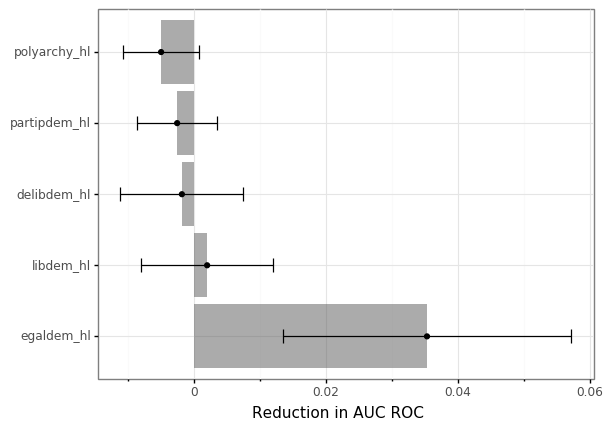

<ggplot: (-9223371938197779848)>

In [793]:
# view plot
myplot

Relatively, egaldem_hl is the only variable that matters. The other variables are of very low importance  as they have negative variable importance which means that random permutations of these variables actually perform better than the variables themselves.

### with `eli5`

Initialize the `PermutationImportance` class object. 

In [753]:
perm_train = PermutationImportance(knn_mod,
                                   n_iter=5,random_state=123)

Fit it using the train (or test!) data

In [754]:
perm_train.fit(train_X,train_y)

PermutationImportance(estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                                ('model',
                                                 KNeighborsClassifier(n_neighbors=50))]),
                      random_state=123)

We can immediately extract the weights as a data frame. 

In [755]:
vi2 = eli5.explain_weights_df(perm_train,feature_names = list(train_X))
vi2

,feature,weight,std
0,egaldem_hl,0.031309,0.009520
1,libdem_hl,0.001080,0.005357
2,partipdem_hl,-0.001350,0.003077
3,delibdem_hl,-0.003779,0.001010
4,polyarchy_hl,-0.003779,0.000540


We can then just plot as we did above. 

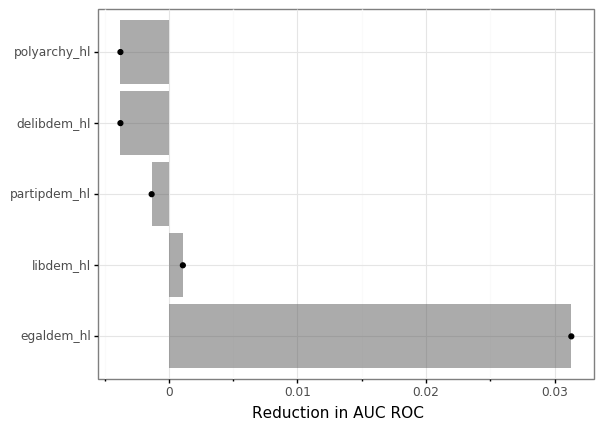

<ggplot: (-9223371938193632380)>

In [756]:
# Plot
(
    ggplot(vi2,
          aes(x="feature",y="weight")) +
    geom_col(alpha=.5) +
    geom_point() +
    theme_bw() + 
    scale_x_discrete(limits=vi2.feature.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

With the eli5 variable importance results, libdem_hl is relatively a better predictor than before (since the variable importance is positive as opposed to negative). However, it is still quite unimportant compared to egaldem_hl.

## ICE Plots

### with `pdpbox`

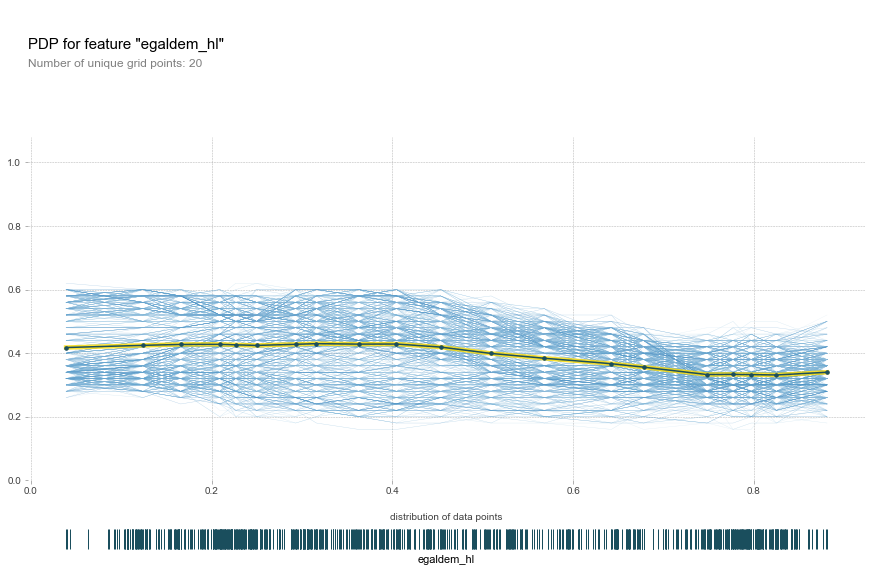

In [760]:
pdp_dist = pdp.pdp_isolate(model = knn_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="egaldem_hl",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'egaldem_hl',plot_pts_dist=True,
                      center=False,plot_lines=True, # ICE part                          
                      figsize=(15,10))

**centering** the plot around the baseline (minimum) value of the variable of interest. 

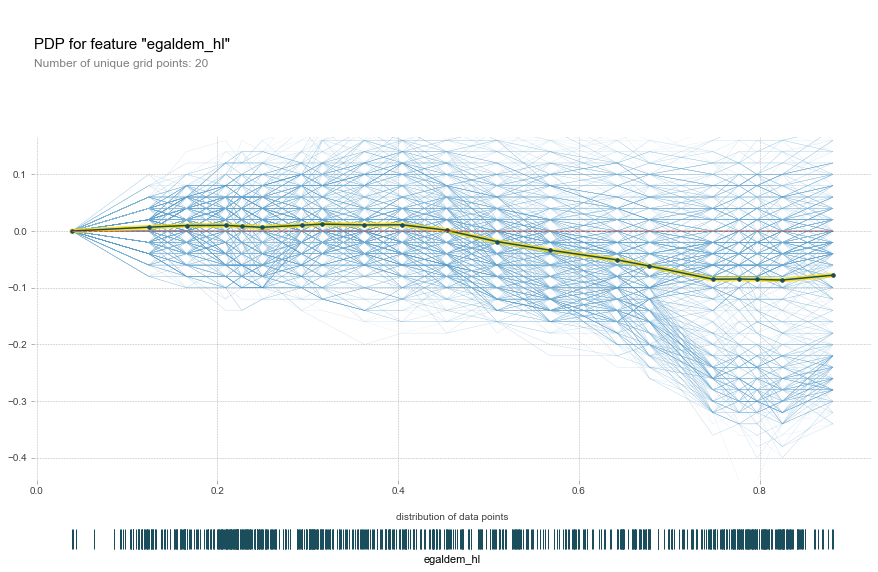

In [761]:
pdp_dist = pdp.pdp_isolate(model = knn_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="egaldem_hl",num_grid_points=20)

fig,ax = pdp.pdp_plot(pdp_dist,'egaldem_hl',plot_pts_dist=True,
                      center=True,plot_lines=True, # ICE part                          
                      figsize=(15,10))

There's evidence here that there is a lot of heterogeneity (or a lot of interaction) in this model since generally the data is not moving in the same flow.  